# In this Notebook, a model of the ***thylakoid system*** of chloroplasts is built using ***PyVista*** using as reference a cryo-EM structure.

## This work is part of the PhD thesis by Rubi Zarmiento Garcia

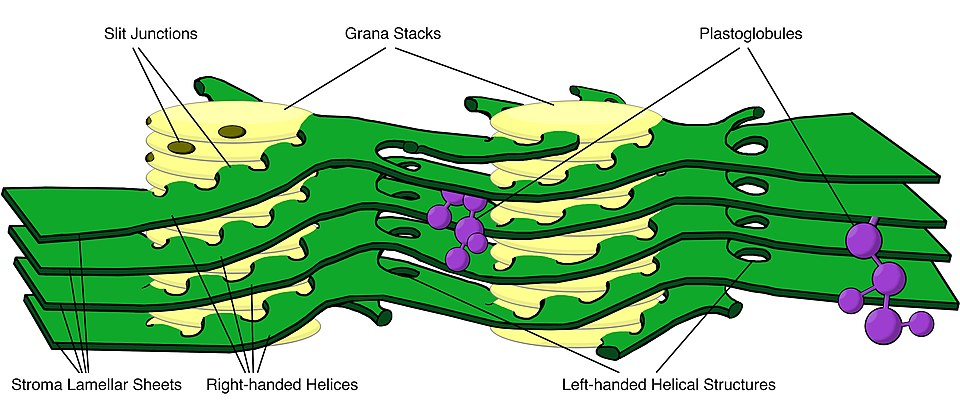

### References:
`Images and cryo-EM data`: Bussi, Y., Shimoni, E., Weiner, A., Kapon, R., Charuvi, D., Nevo, R., ... & Reich, Z. (2019). Fundamental helical geometry consolidates the plant photosynthetic membrane. Proceedings of the National Academy of Sciences, 116(44), 22366-22375.

# Install the required packages


In [1]:
#!pip install pyvista
#!pip install pyacvd
#!pip install trame trame-client trame-server trame-vtk
#!pip install trame-vuetify trame-components # Install UI components including vuetify
#!pip install trame-plotly trame-vega # Install additional packages that might be required
#!pip install MDAnalysis
#!pip install trimesh
#!pip install open3d

# Import the libraries

In [2]:
import pyvista as pv
import pyacvd
import matplotlib.pyplot as plt
import numpy as np
import trimesh
import math
from scipy.optimize import minimize
import os
import json
import meshpy.triangle as triangle
from scipy.spatial import distance


# Load the Fucntions

In [156]:
def area_cylinder(radius, height):
    """
    Calculate the surface area and lateral area of a cylinder.
    
    Parameters:
    radius (float): Radius of the cylinder
    height (float): Height of the cylinder
    
    Returns:
    tuple: (lateral_area, total_surface_area)
    """
    lateral_area = 2 * np.pi * radius * height
    base_area = np.pi * radius**2
    total_surface_area = lateral_area + 2 * base_area
    return total_surface_area

def volume_cylinder(radius, height):
    """
    Calculate the volume of a cylinder.
    
    Parameters:
    radius (float): Radius of the cylinder
    height (float): Height of the cylinder
    
    Returns:
    float: Volume of the cylinder
    """
    return np.pi * radius**2 * height

In [157]:
def print_faces_area(mesh):
    """
    Print the statistics of the faces' area of a mesh.
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to analyze.
    Returns
    -------
    area : np.ndarray
        The area of the faces.
    """
    area = mesh.compute_cell_sizes().cell_data['Area']
    print(f"Number of faces: {area.size}")
    print(f"Mean area: {area.mean()}")
    print(f"Std area: {area.std()}")
    print(f"Min area: {area.min()}")
    print(f"Max area: {area.max()}")
    return area

#Function to plot the area histogram
def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

def remesh_surface(mesh, n_points=20000, subdivision=1):
    """
    Remesh a surface to have more uniform triangle distribution using ACVD algorithm.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Input mesh to be remeshed.
    
    n_points : int, default: 20000
        Target number of points for the remeshed surface.
    
    subdivision : int, default: 1
        Number of subdivisions to perform before clustering.
        Higher values create more input points for potentially better results.
    
    Returns
    -------
    pyvista.PolyData
        Remeshed surface with more uniform triangle distribution.
    
    Notes
    -----
    This function uses the Approximated Centroidal Voronoi Diagrams (ACVD)
    algorithm to create a more uniform triangulation of the input mesh.
    
    Examples
    --------
    >>> import pyvista as pv
    >>> from pyvista import examples
    >>> # Download example mesh
    >>> mesh = examples.download_cow()
    >>> # Remesh with 5000 points
    >>> uniform_mesh = remesh_surface(mesh, n_points=5000)
    """
    import pyacvd
    
    # Create the clustering object
    clus = pyacvd.Clustering(mesh)
    
    # Subdivide mesh for better clustering results if requested
    if subdivision > 1:
        clus.subdivide(subdivision)
    
    # Generate clusters
    clus.cluster(n_points)
    
    # Generate and return remeshed surface
    remeshed = clus.create_mesh()
    
    return remeshed

In [158]:
def simple_vertical_helix(height=10, radius=5, turns=3, n_points=100, handedness="right"):
    """
    Generate a simple vertical helix along the z-axis with specified handedness.

    Parameters
    ----------
    height : float, default: 10
        Total height of the helix.
        
    radius : float, default: 5
        Radius of the helix.
        
    turns : int or float, default: 3
        Number of complete turns in the helix.
        
    n_points : int, default: 100
        Number of points to generate along the helix.

    handedness : str, default: "right"
        Handedness of the helix. Must be either "right" or "left".
        Right-handed helix turns clockwise as it moves away from the viewer.
        Left-handed helix turns counter-clockwise as it moves away from the viewer.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the (x, y, z) coordinates 
        of points along the helix.
        
    Examples
    --------
    >>> # Create a right-handed helix (default)
    >>> points_right = simple_vertical_helix(height=10, radius=5, turns=3)
    >>> 
    >>> # Create a left-handed helix
    >>> points_left = simple_vertical_helix(height=10, radius=5, turns=3, handedness="left")
    """
    
    # Validate handedness parameter
    if handedness.lower() not in ["right", "left"]:
        raise ValueError("handedness must be either 'right' or 'left'")
    
    # Set handedness factor (1 for right-handed, -1 for left-handed)
    chirality = 1 if handedness.lower() == "right" else -1
    
    # Generate parameter space
    t = np.linspace(0, 1, n_points) #This creates a linear space from 0 to 1 with n_points points, e.g., [0, 0.01, ..., 1]
    theta = 2 * np.pi * turns * t # This creates a linear space from 0 to 2*pi*turns with n_points points e.g., [0, 0.0628, ..., 6.2832] for turns=3
    
    # Create helix coordinates
    x = radius * np.cos(theta) 
    y = chirality * radius * np.sin(theta)  # Chirality affects the y-coordinate
    z = height * t
    
    return np.column_stack((x, y, z)) 

def generate_helix_spline(x0=0, y0=0, z0=0, radius=1.0, pitch=2.0, turns=3.0, 
                         n_points=200, chirality='right'):
    """
    Generate a 3D helix spline starting from (x0, y0, z0).
    
    Parameters
    ----------
    x0, y0, z0 : float
        Starting coordinates
    radius : float
        Radius of the helix
    pitch : float
        Vertical distance per complete turn
    turns : float
        Number of complete turns
    n_points : int
        Number of points along the helix
    chirality : str
        Handedness of the helix ('right' or 'left')
    
    Returns
    -------
    points : np.ndarray
        Array of shape (n_points, 3) containing helix coordinates
    """
    # Parameter t goes from 0 to 2*pi*turns
    t = np.linspace(0, 2 * np.pi * turns, n_points)
    
    # Chirality factor: right-handed (+1) or left-handed (-1)
    chiral_factor = 1 if chirality.lower() == 'right' else -1
    
    # Helix equations
    x = x0 + radius * np.cos(t)
    y = y0 + chiral_factor * radius * np.sin(t)  # Chirality affects y component
    z = z0 + (pitch / (2 * np.pi)) * t
    
    # Stack into points array
    points = np.column_stack([x, y, z])
    return points


def plot_spline_helix(spline_points):
    """
    Plot the spline helix using matplotlib.

    Parameters
    ----------
    spline_points : np.ndarray
        Array of points representing the spline helix.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the spline helix
    ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2])
    
    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

def create_elliptical_tube(spline_points, major_radius=1.0, minor_radius=0.5, n_points=20, 
                           align_to_global=True, closed=False):
    """
    Create a tube with elliptical cross-section around a set of spline points using Bishop frames.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    major_radius : float, default: 1.0
        Major radius of the elliptical cross-section.
        
    minor_radius : float, default: 0.5
        Minor radius of the elliptical cross-section.
        
    n_points : int, default: 20
        Number of points to use for each cross-section.
        
    align_to_global : bool, default: True
        Whether to align the major axis with the global coordinates when possible.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the elliptical tube.
    """
    import numpy as np
    import pyvista as pv
    
    # Calculate tangents and path lengths
    tangents = np.gradient(spline_points, axis=0)
    tangent_magnitudes = np.sqrt(np.sum(tangents**2, axis=1))
    tangents = tangents / tangent_magnitudes[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Create elliptical cross-section template
    theta = np.linspace(0, 2*np.pi, n_points, endpoint=False)
    ellipse = np.column_stack((
        major_radius * np.cos(theta),
        minor_radius * np.sin(theta),
        np.zeros_like(theta)
    ))
    
    # Generate Bishop frame
    # Bishop frame minimizes rotation by removing the torsion component
    
    # Initialize reference frame
    t0 = tangents[0]
    
    # Choose reference vectors
    global_refs = [np.array([0, 0, 1]), np.array([1, 0, 0]), np.array([0, 1, 0])]
    
    # Find a reference vector that's not parallel to t0
    reference = global_refs[0]
    for ref in global_refs:
        if not np.isclose(np.abs(np.dot(t0, ref)), 1.0):
            reference = ref
            break
    
    # Create initial frame
    n0 = np.cross(t0, reference)
    n0 = n0 / np.linalg.norm(n0)
    b0 = np.cross(t0, n0)
    b0 = b0 / np.linalg.norm(b0)
    
    # Store frames
    frames = [(t0, n0, b0)]
    
    # Generate Bishop frames along the curve
    for i in range(1, len(spline_points)):
        t_prev, n_prev, b_prev = frames[-1]
        t_curr = tangents[i]
        
        # Transport the previous frame to current point
        # Compute the rotation from previous tangent to current tangent
        axis = np.cross(t_prev, t_curr)
        axis_norm = np.linalg.norm(axis)
        
        if axis_norm > 1e-10:
            # Rotation needed - tangent direction changed
            axis = axis / axis_norm
            cos_angle = np.dot(t_prev, t_curr)
            # Handle numerical issues
            if cos_angle > 1.0:
                cos_angle = 1.0
            elif cos_angle < -1.0:
                cos_angle = -1.0
            angle = np.arccos(cos_angle)
            
            # Apply Rodrigues rotation formula to n and b
            sin_angle = np.sin(angle)
            n_curr = n_prev * np.cos(angle) + \
                     np.cross(axis, n_prev) * sin_angle + \
                     axis * np.dot(axis, n_prev) * (1 - np.cos(angle))
                     
            b_curr = b_prev * np.cos(angle) + \
                     np.cross(axis, b_prev) * sin_angle + \
                     axis * np.dot(axis, b_prev) * (1 - np.cos(angle))
        else:
            # No rotation needed - tangent direction unchanged
            n_curr = n_prev
            b_curr = b_prev
        
        # Ensure orthogonality and unit length
        n_curr = n_curr - np.dot(n_curr, t_curr) * t_curr
        n_curr = n_curr / np.linalg.norm(n_curr)
        b_curr = np.cross(t_curr, n_curr)
        
        frames.append((t_curr, n_curr, b_curr))
    
    # Generate tube mesh
    for i, point in enumerate(spline_points):
        t, n, b = frames[i]
        
        # Create rotation matrix to orient ellipse
        rotation = np.column_stack((n, b, t))
        
        # Align major axis consistently if requested
        if align_to_global:
            # Try to align with global up when reasonable
            global_up = np.array([0, 0, 1])
            alignment = np.abs(np.dot(t, global_up))
            
            # If the tube is more horizontal than vertical
            if alignment < 0.7:  
                # Project global up onto the plane perpendicular to t
                proj_up = global_up - np.dot(global_up, t) * t
                norm_proj = np.linalg.norm(proj_up)
                
                if norm_proj > 1e-6:
                    # Use this as the new normal
                    n = proj_up / norm_proj
                    b = np.cross(t, n)
                    rotation = np.column_stack((n, b, t))
        
        # Transform ellipse points to this position
        for e in ellipse:
            # Rotate and translate ellipse point
            tube_points.append(point + np.dot(rotation, e))
        
        # Create faces between this circle and the previous one
        if i > 0:
            for j in range(n_points):
                idx1 = (i-1) * n_points + j
                idx2 = (i-1) * n_points + (j+1) % n_points
                idx3 = i * n_points + (j+1) % n_points
                idx4 = i * n_points + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested
    if closed and len(spline_points) > 2:
        # Connect last cross-section to first
        for j in range(n_points):
            idx1 = (len(spline_points)-1) * n_points + j
            idx2 = (len(spline_points)-1) * n_points + (j+1) % n_points
            idx3 = (j+1) % n_points
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])
    
    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points to use for each cross-section.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    
    # Calculate tangents and path lengths
    tangents = np.gradient(spline_points, axis=0)
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section template
    half_width = width / 2.0
    half_height = height / 2.0
    
    rectangle = np.array([
        [-half_width, -half_height, 0],
        [ half_width, -half_height, 0],
        [ half_width,  half_height, 0],
        [-half_width,  half_height, 0]
    ])
    
    # Generate tube mesh
    for i, point in enumerate(spline_points):
        t = tangents[i]
        
        # Create rotation matrix to orient rectangle along tangent
        rotation = np.eye(3)
        
        # Transform rectangle points to this position
        for e in rectangle:
            # Rotate and translate rectangle point
            tube_points.append(point + np.dot(rotation, e))
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(4):
                idx1 = (i-1) * 4 + j
                idx2 = (i-1) * 4 + (j+1) % 4
                idx3 = i * 4 + (j+1) % 4
                idx4 = i * 4 + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    # Close the loop if requested   
    if closed and len(spline_points) > 2:
        # Connect last cross-section to first
        for j in range(4):
            idx1 = (len(spline_points)-1) * 4 + j
            idx2 = (len(spline_points)-1) * 4 + (j+1) % 4
            idx3 = (j+1) % 4
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

def create_elliptical_helix(x0=0, y0=0, z0=0, radius_x=2.0, radius_y=1.0, 
                          pitch=2.0, turns=3.0, n_points=200, chirality='right'):
    """
    Create an elliptical helix spline with two different radii.
    
    Parameters
    ----------
    x0, y0, z0 : float
        Starting coordinates of the helix center.
        
    radius_x : float, default: 2.0
        Radius in the X direction (semi-major axis).
        
    radius_y : float, default: 1.0
        Radius in the Y direction (semi-minor axis).
        
    pitch : float, default: 2.0
        Vertical distance per complete turn.
        
    turns : float, default: 3.0
        Number of complete turns.
        
    n_points : int, default: 200
        Number of points along the helix.
        
    chirality : str, default: 'right'
        Handedness of the helix ('right' or 'left').
    
    Returns
    -------
    points : np.ndarray
        Array of shape (n_points, 3) containing elliptical helix coordinates.
    """
    # Parameter t goes from 0 to 2*pi*turns
    t = np.linspace(0, 2 * np.pi * turns, n_points)
    
    # Chirality factor: right-handed (+1) or left-handed (-1)
    chiral_factor = 1 if chirality.lower() == 'right' else -1
    
    # Elliptical helix equations
    x = x0 + radius_x * np.cos(t)
    y = y0 + chiral_factor * radius_y * np.sin(t)  # Different radius for elliptical shape
    z = z0 + (pitch / (2 * np.pi)) * t
    
    # Stack into points array
    points = np.column_stack([x, y, z])
    return points

In [159]:
def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

In [160]:
def forbidden_cylinder(tree,mesh, center, radius, height):
    """
    Given a point, get all mesh points inside a cylinder around it.

    Parameters
    ----------
    tree : scipy.spatial.cKDTree
        KDTree for fast nearest neighbor search.
    mesh : pyvista.PolyData
        The mesh to analyze.
    center : np.ndarray
        The center point of the cylinder.
    radius : float
        The radius of the cylinder.
    height : float
        The height of the cylinder.
    Returns
    -------
    np.ndarray
        The indices of the points inside the cylinder.
    """
    # Calculate the search radius for pre-filtering
    # This is the radius of a sphere that contains the cylinder
    search_radius = np.sqrt(radius**2 + (height/2)**2)
    
    # Use KD-Tree to find all points within the search radius (fast pre-filtering)
    candidate_indices = tree.query_ball_point(center, search_radius)
    #print(f"Center: {center}")
    #print(f"Candidate indices: {candidate_indices}")

    # If no candidates found, return empty array
    if len(candidate_indices) == 0:
        return np.array([], dtype=int)

    return candidate_indices

def distribute_points_gaussian(mesh, n_points=100, mean_distance=21.2, std_distance=3.1, 
                               max_attempts=10000, forbiden_radius=11, forbiden_height=6, seed=None):
    """
    Distribute points on a mesh surface following a Gaussian nearest-neighbor distance distribution.
    
    Uses a modified Poisson disc sampling approach that targets distances from a Gaussian distribution.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        Mesh on which to distribute points.
        
    n_points : int, default: 100
        Number of points to distribute.
        
    mean_distance : float, default: 21.2
        Mean of the Gaussian nearest-neighbor distance distribution.
        
    std_distance : float, default: 3.1
        Standard deviation of the Gaussian nearest-neighbor distance distribution.
        
    max_attempts : int, default: 10000
        Maximum attempts to place each point.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the distributed points.
    """
    import numpy as np
    import pyvista as pv
    from scipy.spatial import cKDTree
    
    #All points tree
    all_points_tree = cKDTree(mesh.points)

    # Set random seed if provided, it will be used in all random operations
    if seed is not None:
        np.random.seed(seed)
    
    # Generate target distances from Gaussian distribution
    target_distances = generate_nn_distances(n_points, mean_distance, std_distance)
    target_distances = np.sort(target_distances)  # Sort for better placement strategy
    
    # Initialize output points array
    points = np.zeros((n_points, 3))
    n_placed = 0
    
    # Place first point randomly on the surface
    random_idx = np.random.randint(mesh.n_points)
    points[0] = mesh.points[random_idx]
    n_placed = 1
    
    # Create KD-Tree for efficient nearest neighbor searches
    # The KD-Tree is a data structure that allows for fast nearest neighbor searches and has the structure of a binary tree
    # It is built from the points we have placed so far
    # We'll update this as we add points
    tree = cKDTree(points[:1]) #Start with the first point
    
    # Create a forbidden cylinder around the first point
    forbidden_points = forbidden_cylinder(all_points_tree, mesh, points[0], forbiden_radius, forbiden_height,
                                          )
    # Try to place remaining points
    for i in range(1, n_points):

        target_dist = target_distances[i-1]  # Use i-1 because we've placed 1 point already
        
        success = False
        for attempt in range(max_attempts):
            # Pick a random point on the mesh
            candidate_idx = np.random.randint(mesh.n_points)

            #Check if the index is in the forbidden points
            if candidate_idx in forbidden_points:
                continue

            candidate_point = mesh.points[candidate_idx]

            # Find distance to nearest existing point
            dist, _ = tree.query(candidate_point.reshape(1, -1))
            nearest_dist = dist[0]
            
            # Accept if it's close enough to our target distance
            # Use a tolerance that gets wider with more attempts
            tolerance = std_distance * (1.0 + attempt * 0.1)
            if abs(nearest_dist - target_dist) <= tolerance:
                points[n_placed] = candidate_point
                n_placed += 1
                
                # Update KD-Tree with new point
                tree = cKDTree(points[:n_placed])
                success = True

                # Create a new forbidden cylinder around the new point
                new_forbidden_points = forbidden_cylinder(all_points_tree, mesh, candidate_point, forbiden_radius, forbiden_height)

                if any(idx in forbidden_points for idx in new_forbidden_points):
                    continue  # Skip this candidate, it would create overlapping forbidden regions
                # Check if the new forbidden points exist, then we shouldn't place it there
                # Add the new forbidden points to the existing ones
                # Remove duplicates
                forbidden_points = np.unique(forbidden_points)
                print(len(forbidden_points))

                break
        
        # If we couldn't place this point after max_attempts, warn but continue
        if not success:
            print(f"Warning: Could not place point {i+1} after {max_attempts} attempts.")
            
            # Place a point anyway - pick a random surface point that's not too close to others
            for fallback_attempt in range(100):
                candidate_idx = np.random.randint(mesh.n_points)
                candidate_point = mesh.points[candidate_idx]
                dist, _ = tree.query(candidate_point.reshape(1, -1))
                
                # Accept if it's not too close to existing points
                if dist[0] > mean_distance * 0.5:
                    points[n_placed] = candidate_point
                    n_placed += 1
                    tree = cKDTree(points[:n_placed])
                    break
    
    # Analyze the resulting distribution
    if n_placed == n_points:
        # Calculate achieved NN distances
        tree = cKDTree(points)
        distances, _ = tree.query(points, k=2)
        achieved_distances = distances[:, 1]  # Second column is distance to nearest non-self neighbor
        
        # Print statistics
        print(f"Target distribution:  mean={mean_distance:.2f}, std={std_distance:.2f}")
        print(f"Achieved distribution: mean={np.mean(achieved_distances):.2f}, std={np.std(achieved_distances):.2f}")
    else:
        print(f"Warning: Only placed {n_placed} out of {n_points} points.")
    
    # Get positions of the forbidden points
    forbidden_points = mesh.points[forbidden_points]

    return points[:n_placed], forbidden_points


def analyze_point_distribution(points, target_mean=21.2, target_std=3.1):
    """
    Analyze the nearest-neighbor distance distribution of a set of points.
    
    Parameters
    ----------
    points : np.ndarray
        Array of shape (n_points, 3) containing point coordinates.
        
    target_mean : float, default: 21.2
        Target mean distance for comparison.
        
    target_std : float, default: 3.1
        Target standard deviation for comparison.
        
    Returns
    -------
    dict
        Dictionary containing distribution statistics and comparison metrics.
    """
    from scipy.spatial import cKDTree
    from scipy import stats
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate nearest neighbor distances
    tree = cKDTree(points)
    distances, _ = tree.query(points, k=2)
    nn_distances = distances[:, 1]  # Distances to nearest non-self neighbors
    
    # Calculate statistics
    actual_mean = np.mean(nn_distances)
    actual_std = np.std(nn_distances)
    
    # Generate target distribution for comparison
    n_points = len(points)
    target_distances = np.random.normal(target_mean, target_std, n_points)
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, ks_pvalue = stats.kstest(nn_distances, 'norm', 
                                           args=(target_mean, target_std))
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of distances
    ax1.hist(nn_distances, bins=20, alpha=0.7, label='Actual')
    ax1.hist(target_distances, bins=20, alpha=0.5, label='Target')
    ax1.set_xlabel('Nearest Neighbor Distance')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distance Distribution Comparison')
    ax1.legend()
    
    # QQ plot
    stats.probplot(nn_distances, dist=stats.norm(loc=target_mean, scale=target_std), 
                  plot=ax2)
    ax2.set_title('Q-Q Plot vs. Target Gaussian')
    
    plt.tight_layout()
    
    # Return results
    results = {
        'actual_mean': actual_mean,
        'actual_std': actual_std,
        'target_mean': target_mean,
        'target_std': target_std,
        'ks_statistic': ks_statistic,
        'ks_pvalue': ks_pvalue,
        'nn_distances': nn_distances,
        'figure': fig
    }
    
    return results

In [161]:
def generate_nn_distances(n_points, mean=21.2, std=3.1, seed=None):
    """
    Generate random distances from a Gaussian distribution.

    Parameters
    ----------
    n_points : int
        Number of distances to generate.
        
    mean : float, default: 21.2
        Mean of the Gaussian distribution.
        
    std : float, default: 3.1
        Standard deviation of the Gaussian distribution.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_points,) containing the generated distances.
    """
    #Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=n_points)

def plot_area_histogram(list_area):
    """
    Compare the area of the faces of two meshes

    Parameters
    ----------
    list_area : list
        List of arrays containing the areas of the faces of two meshes
    ----------
    Returns
    -------
    None
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create histogram for each mesh
    for i, area in enumerate(list_area):
        ax.hist(area, bins=100, alpha=0.5, label=f'Mesh {i+1}')

    # Add labels and title
    ax.set_xlabel('Area')
    ax.set_ylabel('Frequency')
    ax.set_title('Area Histogram')
    ax.legend()

    # Show the plot
    plt.show()

In [162]:
def parse_mtl_file(mtl_path):
    """Parse MTL file to extract material colors.
    
    Parameters
    ----------
    mtl_path : str
        Path to the MTL file.

    Returns
    -------
    materials : dict
        Dictionary mapping material names to their diffuse RGB colors.
    """
    materials = {}
    current_material = None
    
    with open(mtl_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('newmtl'):
                current_material = line.split()[1]
                materials[current_material] = {}
            elif line.startswith('Kd') and current_material:
                # Diffuse color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['diffuse'] = rgb
            elif line.startswith('Ka') and current_material:
                # Ambient color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['ambient'] = rgb
            elif line.startswith('Ks') and current_material:
                # Specular color (RGB values 0-1)
                rgb = [float(x) for x in line.split()[1:4]]
                materials[current_material]['specular'] = rgb
    
    return materials

def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    pv_mesh : pyvista.PolyData or list of pyvista.PolyData
        PyVista mesh(es) with material colors as point/cell data attributes.
        Returns single mesh if OBJ contains one object, list if multiple.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes if len(meshes) > 1 else meshes[0]
    
    else:
        # Single mesh
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return pv_mesh

def plot_mesh_with_materials(mesh, show_edges=True, window_size=[800, 600], background_color='white'):
    """Plot mesh with material colors.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        Mesh(es) to plot.
    show_edges : bool, default: True
        Whether to show mesh edges.
    window_size : list, default: [800, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'white'
        Background color for the scene.
    """
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    # Handle single mesh or list of meshes
    if not isinstance(mesh, list):
        mesh = [mesh]
    
    for pv_mesh in mesh:
        # Use material colors if available
        if 'material_color' in pv_mesh.array_names:
            colors = pv_mesh['material_color']
            plotter.add_mesh(pv_mesh, scalars=colors, rgb=True, show_edges=show_edges)
        elif 'face_colors' in pv_mesh.array_names:
            colors = pv_mesh['face_colors']
            plotter.add_mesh(pv_mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges)
        else:
            plotter.add_mesh(pv_mesh, color='lightblue', show_edges=show_edges)
    
    plotter.show()
    return plotter

In [163]:
def create_periodic_copies(mesh, n_copies_x_positive=1, n_copies_x_negative=1,
                           n_copies_y_positive=1, n_copies_y_negative=1,
                           n_copies_z_positive=1, n_copies_z_negative=1, 
                           x_limits=[], y_limits=[], z_limits=[]):
    """Create periodic copies of a mesh in the specified directions.
    
    Parameters
    ----------
    mesh : pyvista.PolyData or list of pyvista.PolyData
        The mesh(es) to copy.
    n_copies_x_positive : int, default: 1
        Number of copies in the positive x direction.
    n_copies_x_negative : int, default: 1
        Number of copies in the negative x direction.
    n_copies_y_positive : int, default: 1
        Number of copies in the positive y direction.
    n_copies_y_negative : int, default: 1
        Number of copies in the negative y direction.
    n_copies_z_positive : int, default: 1
        Number of copies in the positive z direction.
    n_copies_z_negative : int, default: 1
        Number of copies in the negative z direction.
    x_limits : list, default: []
        List of two floats specifying the x limits [xmin, xmax]. If empty, uses mesh bounds.
    y_limits : list, default: []
        List of two floats specifying the y limits [ymin, ymax]. If empty, uses mesh bounds.
    z_limits : list, default: []
        List of two floats specifying the z limits [zmin, zmax]. If empty, uses mesh bounds.
        
    Returns
    -------
    list of pyvista.PolyData
        List containing the original mesh and all periodic copies.
    """
    import pyvista as pv
    import numpy as np
    
    # Handle both single mesh and list of meshes
    if isinstance(mesh, list):
        mesh_list = mesh
    else:
        mesh_list = [mesh]
    
    # Calculate dimensions for translation
    if x_limits:
        x_min, x_max = x_limits
        x_size = x_max - x_min
    else:
        # Get bounds from all meshes
        all_bounds = []
        for m in mesh_list:
            all_bounds.append(m.bounds)
        all_bounds = np.array(all_bounds)
        x_min = all_bounds[:, 0].min()  # minimum x
        x_max = all_bounds[:, 1].max()  # maximum x
        x_size = x_max - x_min
    
    if y_limits:
        y_min, y_max = y_limits
        y_size = y_max - y_min
    else:
        y_min = all_bounds[:, 2].min()  # minimum y
        y_max = all_bounds[:, 3].max()  # maximum y
        y_size = y_max - y_min
    
    if z_limits:
        z_min, z_max = z_limits
        z_size = z_max - z_min
    else:
        z_min = all_bounds[:, 4].min()  # minimum z
        z_max = all_bounds[:, 5].max()  # maximum z
        z_size = z_max - z_min
    
    all_meshes = []
    
    # Generate all translation vectors
    for i in range(-n_copies_x_negative, n_copies_x_positive + 1):
        for j in range(-n_copies_y_negative, n_copies_y_positive + 1):
            for k in range(-n_copies_z_negative, n_copies_z_positive + 1):
                
                # Calculate translation vector
                translation = np.array([
                    i * x_size,
                    j * y_size,
                    k * z_size
                ])
                
                # Create copies of all meshes with this translation
                for original_mesh in mesh_list:
                    if i == 0 and j == 0 and k == 0:
                        # Original mesh (no translation)
                        all_meshes.append(original_mesh.copy())
                    else:
                        # Create translated copy using manual translation
                        translated_mesh = original_mesh.copy()
                        translated_mesh.points = translated_mesh.points + translation
                        all_meshes.append(translated_mesh)
    
    return all_meshes

def plot_periodic_copies(periodic_meshes, show_edges=False, window_size=[1600, 600], 
                        background_color='black', opacity=1.0):
    """Plot a list of periodic mesh copies.
    
    Parameters
    ----------
    periodic_meshes : list of pyvista.PolyData
        List of meshes to plot (typically output from create_periodic_copies).
    show_edges : bool, default: False
        Whether to show mesh edges.
    window_size : list, default: [1600, 600]
        Window size for the plotter.
    background_color : str or tuple, default: 'black'
        Background color for the scene.
    opacity : float, default: 1.0
        Opacity for all meshes (0.0 to 1.0).
        
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    import pyvista as pv
    
    plotter = pv.Plotter(window_size=window_size)
    plotter.background_color = background_color
    
    for mesh in periodic_meshes:
        # Use material colors if available
        if 'material_color' in mesh.array_names:
            colors = mesh['material_color']
            plotter.add_mesh(mesh, scalars=colors, rgb=True, show_edges=show_edges, 
                           opacity=opacity)
        elif 'face_colors' in mesh.array_names:
            colors = mesh['face_colors']
            plotter.add_mesh(mesh, scalars=colors[:, :3], rgb=True, show_edges=show_edges,
                           opacity=opacity)
        else:
            plotter.add_mesh(mesh, color='lightblue', show_edges=show_edges, 
                           opacity=opacity)
    
    plotter.show()
    return plotter

In [164]:
def load_obj_with_materials(obj_path, mtl_path=None):
    """Load OBJ file and return PyVista mesh with material colors as attributes.
    
    Parameters
    ----------
    obj_path : str
        Path to the OBJ file.
    mtl_path : str, optional
        Path to the MTL file containing material definitions.

    Returns
    -------
    list of pyvista.PolyData
        Always returns a list of PyVista mesh(es) with material colors as point/cell data attributes.
    """
    # Parse materials if MTL file provided
    materials = {}
    if mtl_path:
        materials = parse_mtl_file(mtl_path)
    
    # Load mesh with trimesh
    scene = trimesh.load(obj_path)
    
    if isinstance(scene, trimesh.Scene):
        # Handle multiple objects in scene
        meshes = []
        
        for name, mesh in scene.geometry.items():
            # Create PyVista mesh manually to avoid UV issues
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
            pv_mesh = pv.PolyData(vertices, cells)
            
            # Add material information as mesh attributes
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'material'):
                if hasattr(mesh.visual.material, 'name'):
                    material_name = mesh.visual.material.name
                    pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                    
                    # Add color information if material exists
                    if material_name in materials:
                        diffuse_color = materials[material_name]['diffuse']
                        # Add as point data (RGB values repeated for each point)
                        pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
            
            # Add face colors if available from trimesh
            if hasattr(mesh, 'visual') and hasattr(mesh.visual, 'face_colors'):
                if mesh.visual.face_colors is not None:
                    face_colors = np.asarray(mesh.visual.face_colors)
                    if face_colors.max() > 1.0:
                        face_colors = face_colors / 255.0  # Normalize to 0-1
                    pv_mesh['face_colors'] = face_colors
            
            meshes.append(pv_mesh)
        
        return meshes  # Always return list
    
    else:
        # Single mesh - wrap in list
        vertices = np.asarray(scene.vertices)
        faces = np.asarray(scene.faces)
        cells = np.column_stack([np.full(faces.shape[0], 3), faces]).flatten()
        pv_mesh = pv.PolyData(vertices, cells)
        
        # Add material information if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'material'):
            if hasattr(scene.visual.material, 'name'):
                material_name = scene.visual.material.name
                pv_mesh['material_name'] = [material_name] * pv_mesh.n_points
                
                if material_name in materials:
                    diffuse_color = materials[material_name]['diffuse']
                    pv_mesh['material_color'] = np.tile(diffuse_color, (pv_mesh.n_points, 1))
        
        # Add face colors if available
        if hasattr(scene, 'visual') and hasattr(scene.visual, 'face_colors'):
            if scene.visual.face_colors is not None:
                face_colors = np.asarray(scene.visual.face_colors)
                if face_colors.max() > 1.0:
                    face_colors = face_colors / 255.0
                pv_mesh['face_colors'] = face_colors
        
        return [pv_mesh]  # Always return list, even for single mesh

In [165]:
def cylinder_with_concentric_circles(radius=1.0, height=2.0, radial_resolution=16, 
                                        height_resolution=8, concentric_circles=3, 
                                        center=None, direction=None):
    """
    Generate a simple cylindrical mesh with concentric circles at the top and bottom.

    Parameters
    ----------
    radius : float, default: 1.0
        Radius of the cylinder.
    height : float, default: 2.0
        Height of the cylinder.
    radial_resolution : int, default: 16
        Number of radial segments (sides) of the cylinder.
    height_resolution : int, default: 8
        Number of segments along the height of the cylinder.
    concentric_circles : int, default: 3
        Number of concentric circles at the top and bottom of the cylinder.
    center : array_like, default: [0, 0, 0]
        Center point of the cylinder (middle point along the axis).
    direction : array_like, default: [0, 0, 1]
        Direction vector of the cylinder axis (will be normalized).
    """
    # Default values
    if center is None:
        center = np.array([0.0, 0.0, 0.0])
    else:
        center = np.array(center)
    
    if direction is None:
        direction = np.array([0.0, 0.0, 1.0])
    else:
        direction = np.array(direction)
    
    # Normalize direction vector
    direction = direction / np.linalg.norm(direction)
    
    # Create local coordinate system
    # Find two orthogonal vectors perpendicular to direction
    if abs(direction[2]) < 0.9:  # direction is not too close to z-axis
        u = np.cross(direction, [0, 0, 1])
    else:  # direction is close to z-axis, use x-axis instead
        u = np.cross(direction, [1, 0, 0])
    
    u = u / np.linalg.norm(u)
    v = np.cross(direction, u)
    v = v / np.linalg.norm(v)
    
    vertices = []
    
    # Calculate radii for concentric circles
    circle_radii = np.linspace(0, radius, concentric_circles + 1)[1:]  # Exclude center point
    
    # Create vertices for the cylindrical surface
    for i in range(height_resolution + 1):
        t = i / height_resolution  # Parameter from 0 to 1
        axis_pos = center + direction * (t - 0.5) * height  # Center cylinder on 'center'
        
        for j in range(radial_resolution):
            theta = 2 * np.pi * j / radial_resolution
            
            # Create point in local coordinate system
            local_x = radius * np.cos(theta)
            local_y = radius * np.sin(theta)
            
            # Transform to world coordinates
            world_pos = axis_pos + local_x * u + local_y * v
            vertices.append(world_pos)
    
    # Add cap vertices (top and bottom)
    for t in [0, 1]:  # Bottom (t=0) and top (t=1)
        axis_pos = center + direction * (t - 0.5) * height
        
        # Center point
        vertices.append(axis_pos)
        
        # Concentric circles
        for circle_radius in circle_radii:
            for j in range(radial_resolution):
                theta = 2 * np.pi * j / radial_resolution
                
                # Create point in local coordinate system
                local_x = circle_radius * np.cos(theta)
                local_y = circle_radius * np.sin(theta)
                
                # Transform to world coordinates
                world_pos = axis_pos + local_x * u + local_y * v
                vertices.append(world_pos)
    
    vertices = np.array(vertices)
    faces = []
    
    # Side faces
    for i in range(height_resolution):
        for j in range(radial_resolution):
            curr_base = i * radial_resolution
            next_base = (i + 1) * radial_resolution
            
            curr = curr_base + j
            next_j = curr_base + ((j + 1) % radial_resolution)
            next_i = next_base + j
            next_i_j = next_base + ((j + 1) % radial_resolution)
            
            faces.extend([3, curr, next_j, next_i])
            faces.extend([3, next_j, next_i_j, next_i])
    
    # Cap faces
    surface_vertices = (height_resolution + 1) * radial_resolution
    
    for cap_offset in [0, 1 + len(circle_radii) * radial_resolution]:  # Bottom and top caps
        center_idx = surface_vertices + cap_offset
        
        # Connect center to first ring
        first_ring_start = center_idx + 1
        for j in range(radial_resolution):
            curr = first_ring_start + j
            next_j = first_ring_start + ((j + 1) % radial_resolution)
            
            if cap_offset == 0:  # Bottom cap
                faces.extend([3, center_idx, next_j, curr])
            else:  # Top cap
                faces.extend([3, center_idx, curr, next_j])
        
        # Connect concentric rings
        for ring in range(len(circle_radii) - 1):
            inner_start = center_idx + 1 + ring * radial_resolution
            outer_start = center_idx + 1 + (ring + 1) * radial_resolution
            
            for j in range(radial_resolution):
                inner_curr = inner_start + j
                inner_next = inner_start + ((j + 1) % radial_resolution)
                outer_curr = outer_start + j
                outer_next = outer_start + ((j + 1) % radial_resolution)
                
                if cap_offset == 0:  # Bottom cap
                    faces.extend([3, inner_curr, inner_next, outer_curr])
                    faces.extend([3, inner_next, outer_next, outer_curr])
                else:  # Top cap
                    faces.extend([3, inner_curr, outer_curr, inner_next])
                    faces.extend([3, inner_next, outer_curr, outer_next])
    
    faces = np.array(faces)
    mesh = pv.PolyData(vertices, faces)
    mesh = mesh.clean()
    
    return mesh



def direction_vector(angle, axis='z', towards='x'):
    """
    Create a direction vector at a given angle from a specified axis.
    
    Parameters
    ----------
    angle : float
        Angle in degrees from the specified axis.
    axis : str, default: 'z'
        Reference axis ('x', 'y', or 'z') from which the angle is measured.
    towards : str, default: 'x'
        Direction to tilt towards ('x', 'y', or 'z'), must be different from axis.
        
    Returns
    -------
    np.ndarray
        Unit direction vector at the specified angle from the axis.
    """
    if axis == towards:
        raise ValueError("axis and towards must be different")
    
    angle_rad = np.radians(angle)
    
    if axis == 'z':
        if towards == 'x':
            return np.array([np.sin(angle_rad), 0, np.cos(angle_rad)])
        elif towards == 'y':
            return np.array([0, np.sin(angle_rad), np.cos(angle_rad)])
    
    elif axis == 'x':
        if towards == 'y':
            return np.array([np.cos(angle_rad), np.sin(angle_rad), 0])
        elif towards == 'z':
            return np.array([np.cos(angle_rad), 0, np.sin(angle_rad)])
    
    elif axis == 'y':
        if towards == 'x':
            return np.array([np.sin(angle_rad), np.cos(angle_rad), 0])
        elif towards == 'z':
            return np.array([0, np.cos(angle_rad), np.sin(angle_rad)])
    
    else:
        raise ValueError("axis must be 'x', 'y', or 'z'")

In [166]:
def select_random_points(mesh, n_points=10, seed=None):
    """
    Randomly select points from a mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to select points.
    
    n_points : int, default: 10
        Number of points to select.
        
    seed : int, optional
        Random seed for reproducibility.
        
    Returns
    -------
    np.ndarray
        Array of shape (n_points, 3) containing the coordinates of selected points.
    np.ndarray
        Array of shape (n_points,) containing the indices of selected points.
    """    
    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Get total number of points in the mesh
    total_points = mesh.n_points
    
    # Ensure we don't try to select more points than available
    n_select = min(n_points, total_points)
    
    # Randomly select point indices
    selected_indices = np.random.choice(total_points, size=n_select, replace=False)
    
    # Get the coordinates of these points
    selected_points = mesh.points[selected_indices]
    
    return selected_points, selected_indices


def plot_mesh_with_highlighted_spheres(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    #p.add_points(highlighted_points, 
    #             color=point_color, 
    #             point_size=point_size, 
    #             render_points_as_spheres=True)
    #Add spheres at the highlighted points
    for point in highlighted_points:
        p.add_mesh(pv.Sphere(radius=point_size, center=point), color=point_color)
    # Set a title
    p.add_text(title, font_size=16)
    
    # Show the plot
    p.show()
    
    return p

def plot_mesh_with_highlighted_points(mesh, highlighted_points, 
                                      mesh_color='lightblue', point_color='red',
                                      point_size=15, mesh_opacity=1, show_edges=True,
                                      window_size=[800, 600], title="Mesh with Highlighted Points"):
    """
    Plot a mesh with specific points highlighted.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to plot.
        
    highlighted_points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of points to highlight.
        
    mesh_color : str or tuple, default: 'lightblue'
        Color for the mesh.
        
    point_color : str or tuple, default: 'red'
        Color for the highlighted points.
        
    point_size : int, default: 15
        Size of the highlighted points.
        
    mesh_opacity : float, default: 0.8
        Opacity of the mesh (0.0 to 1.0).
        
    show_edges : bool, default: True
        Whether to show edges of the mesh.
        
    window_size : list, default: [800, 600]
        Size of the plotting window [width, height].
        
    title : str, default: "Mesh with Highlighted Points"
        Title for the plot window.
    
    Returns
    -------
    pyvista.Plotter
        The plotter object used for visualization.
    """
    # Create a plotter
    p = pv.Plotter(window_size=window_size)
    
    # Add the mesh
    p.add_mesh(mesh, 
               color=mesh_color, 
               show_edges=show_edges, 
               opacity=mesh_opacity)
    
    # Add the highlighted points
    p.add_points(highlighted_points, 
                 color=point_color, 
                 point_size=point_size, 
                 render_points_as_spheres=False)

    
    # Show the plot
    p.show()
    
    return p

def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side in local 2D coordinates
    rectangle_2d = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, -half_height])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle_2d.append([half_width, y])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, half_height])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle_2d.append([-half_width, y])
    
    rectangle_2d = np.array(rectangle_2d)
    points_per_section = len(rectangle_2d)
    
    # Generate tube mesh
    for i, center_point in enumerate(resampled_points):
        tangent = tangents[i]
        
        # Create local coordinate system at this point
        # Tangent is the Z-axis of local system
        local_z = tangent
        
        # Create a reasonable local X and Y axis
        # Choose an arbitrary vector not parallel to tangent
        if abs(local_z[2]) < 0.9:
            temp_vector = np.array([0, 0, 1])
        else:
            temp_vector = np.array([1, 0, 0])
        
        # Create local X axis (perpendicular to tangent)
        local_x = np.cross(local_z, temp_vector)
        local_x = local_x / np.linalg.norm(local_x)
        
        # Create local Y axis (perpendicular to both)
        local_y = np.cross(local_z, local_x)
        local_y = local_y / np.linalg.norm(local_y)
        
        # Create rotation matrix from local to global coordinates
        rotation_matrix = np.column_stack([local_x, local_y, local_z])
        
        # Transform rectangle points to 3D and orient them
        for local_point_2d in rectangle_2d:
            # Convert 2D rectangle point to 3D local coordinates
            local_point_3d = np.array([local_point_2d[0], local_point_2d[1], 0])
            
            # Rotate to global orientation and translate to center point
            global_point = center_point + np.dot(rotation_matrix, local_point_3d)
            tube_points.append(global_point)
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))


In [167]:
def mesh_resolution(mesh):
    """
    Compute and print statistics for mesh face areas.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh to analyze.
        
    Returns
    -------
    avg_area : float
        Average area of the mesh faces.
    std_area : float
        Standard deviation of the mesh face areas.
    """
    cell_sizes = mesh.compute_cell_sizes()
    avg_area = cell_sizes['Area'].mean()
    std_area = cell_sizes['Area'].std()
    
    print(f"The mesh has {mesh.n_faces} faces.")
    print(f"The average cell size is {avg_area:.2f} nm^2.")
    print(f"The standard deviation of the cell sizes is {std_area:.2f} nm^2.")
    
    return avg_area, std_area

In [168]:
def helix_pitch_from_tilt(radius, tilt_angle_deg):
    """
    Calculate the helix pitch (axial rise per full turn) 
    given its radius and tilt angle above the horizontal.

    Parameters:
        radius (float): Helix radius R.
        tilt_angle_deg (float): Tilt angle α above horizontal, in degrees.

    Returns:
        float: Pitch P (axial rise per full 360° turn).
    """
    alpha = math.radians(tilt_angle_deg)
    return 2 * math.pi * radius * math.tan(alpha)


def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

def radius_cone_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the radius of a cone required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required cone radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))

In [169]:
def add_material_labels(mesh, material_id, color_name):
    """Add material ID and color labels to any mesh (transferable function)."""
    # Add material ID as cell data (standard VTK approach)
    mesh.cell_data['material_id'] = np.full(mesh.n_cells, material_id)
    
    # Add color information
    mesh.cell_data['color_name'] = [color_name] * mesh.n_cells
    
    # Add RGB color values for visualization
    if color_name == 'red':
        rgb = [1.0, 0.0, 0.0]
    elif color_name == 'blue':
        rgb = [0.0, 0.0, 1.0]
    elif color_name == 'green':
        rgb = [0.0, 1.0, 0.0]
    elif color_name == 'yellow':
        rgb = [1.0, 1.0, 0.0]
    elif color_name == 'purple':
        rgb = [0.5, 0.0, 0.5]
    else:
        rgb = [0.5, 0.5, 0.5]  # default gray
    
    # Add RGB as point data for smooth visualization
    mesh.point_data['rgb_color'] = np.tile(rgb, (mesh.n_points, 1))
    
    return mesh

def add_cell_index_labels(mesh):
    """Add index labels to the mesh cells for visualization."""
    # Create labels as strings
    labels = [i for i in range(mesh.n_cells)]

    # Add as cell data
    mesh.cell_data['index'] = labels
    
    return mesh

In [170]:
def find_helix_intersections(helix1_params, helix2_params, 
                           search_range=(-4*np.pi, 4*np.pi), 
                           tolerance=0.1,
                           grid_resolution=20):
    """
    Find intersection points between two 3D helical splines.
    
    This function uses a hybrid grid search + optimization approach to find
    points where two helices come closest to intersecting.
    
    Parameters:
    -----------
    helix1_params : dict
        First helix parameters with keys:
        - 'center': (x, y, z) tuple for helix center
        - 'radius': float, helix radius  
        - 'pitch': float, vertical distance per full revolution
        - 'axis': str, rotation axis ('x', 'y', or 'z')
        
    helix2_params : dict
        Second helix parameters (same format as helix1_params)
        
    search_range : tuple
        (min_t, max_t) parameter range to search for intersections
        
    tolerance : float
        Maximum distance between points to consider as intersection
        
    grid_resolution : int
        Number of grid points per dimension for initial search
        
    Returns:
    --------
    list of dict
        List of intersection dictionaries, each containing:
        - 'point': (x, y, z) tuple of intersection coordinates
        - 't1': parameter value on first helix
        - 't2': parameter value on second helix  
        - 'distance': actual distance between closest points
        
        Results are sorted by distance (best matches first)
        
    Example:
    --------
    >>> helix1 = {'center': (0,0,0), 'radius': 1.0, 'pitch': 2.0, 'axis': 'z'}
    >>> helix2 = {'center': (0,0,0), 'radius': 1.0, 'pitch': 2.0, 'axis': 'x'}
    >>> intersections = find_helix_intersections(helix1, helix2)
    >>> print(f"Found {len(intersections)} intersections")
    """
    
    def helix_point(t, center, radius, pitch, axis='z'):
        """Calculate 3D point on helix at parameter value t."""
        cx, cy, cz = center
        
        if axis == 'z':
            # Helix around z-axis
            x = cx + radius * np.cos(t)
            y = cy + radius * np.sin(t) 
            z = cz + pitch * t / (2 * np.pi)
        elif axis == 'x':
            # Helix around x-axis
            x = cx + pitch * t / (2 * np.pi)
            y = cy + radius * np.cos(t)
            z = cz + radius * np.sin(t)
        elif axis == 'y':
            # Helix around y-axis
            x = cx + radius * np.cos(t)
            y = cy + pitch * t / (2 * np.pi)
            z = cz + radius * np.sin(t)
        else:
            raise ValueError(f"Invalid axis '{axis}'. Must be 'x', 'y', or 'z'")
            
        return np.array([x, y, z])
    
    def distance_between_helices(params):
        """Calculate distance between points on both helices."""
        t1, t2 = params
        try:
            point1 = helix_point(t1, **helix1_params)
            point2 = helix_point(t2, **helix2_params)
            return np.linalg.norm(point1 - point2)
        except:
            return 1e6  # Return large value for invalid parameters
    
    # Step 1: Grid search to find candidate regions
    t_min, t_max = search_range
    t_values = np.linspace(t_min, t_max, grid_resolution)
    
    candidates = []
    for t1 in t_values:
        for t2 in t_values:
            distance = distance_between_helices([t1, t2])
            if distance < tolerance:
                candidates.append((t1, t2, distance))
    
    # Step 2: Refine candidates using optimization
    intersections = []
    
    for t1_init, t2_init, _ in candidates:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                
                # Use Nelder-Mead optimization for robustness
                result = minimize(
                    distance_between_helices,
                    [t1_init, t2_init],
                    method='Nelder-Mead',
                    options={'xatol': 1e-8, 'fatol': 1e-10, 'maxiter': 1000}
                )
            
            if result.success and result.fun < tolerance:
                t1_opt, t2_opt = result.x
                
                # Calculate intersection point as midpoint
                point1 = helix_point(t1_opt, **helix1_params)
                point2 = helix_point(t2_opt, **helix2_params)
                intersection_point = (point1 + point2) / 2
                
                # Check for duplicate intersections
                is_duplicate = False
                for existing in intersections:
                    existing_point = np.array(existing['point'])
                    if np.linalg.norm(intersection_point - existing_point) < tolerance:
                        is_duplicate = True
                        break
                
                if not is_duplicate:
                    intersections.append({
                        'point': tuple(intersection_point),
                        't1': t1_opt,
                        't2': t2_opt,
                        'distance': result.fun
                    })
                    
        except Exception:
            # Skip failed optimizations
            continue
    
    # Step 3: Sort results by distance quality
    intersections.sort(key=lambda x: x['distance'])
    
    return intersections

def plot_helices_simple(helix1_params, helix2_params, intersections):
    """
    Simple 3D plot of two helices and their intersection points.
    """
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate helix points for plotting
    t = np.linspace(-3*np.pi, 3*np.pi, 500)
    
    # Helix 1 points
    def helix_coords(t, center, radius, pitch, axis):
        cx, cy, cz = center
        if axis == 'z':
            return (cx + radius * np.cos(t), 
                   cy + radius * np.sin(t), 
                   cz + pitch * t / (2 * np.pi))
        elif axis == 'x':
            return (cx + pitch * t / (2 * np.pi),
                   cy + radius * np.cos(t), 
                   cz + radius * np.sin(t))
        elif axis == 'y':
            return (cx + radius * np.cos(t),
                   cy + pitch * t / (2 * np.pi), 
                   cz + radius * np.sin(t))
    
    # Plot first helix
    x1, y1, z1 = helix_coords(t, **helix1_params)
    ax.plot(x1, y1, z1, 'blue', linewidth=3, alpha=0.8, label=f'Helix 1 ({helix1_params["axis"]}-axis)')
    
    # Plot second helix
    x2, y2, z2 = helix_coords(t, **helix2_params)
    ax.plot(x2, y2, z2, 'red', linewidth=3, alpha=0.8, label=f'Helix 2 ({helix2_params["axis"]}-axis)')
    
    # Plot intersection points
    if intersections:
        coords = np.array([inter['point'] for inter in intersections])
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                  c='gold', s=150, marker='o', edgecolors='black', linewidth=2,
                  label=f'{len(intersections)} Intersections', zorder=10)
        
        # Add numbers to intersection points
        for i, inter in enumerate(intersections):
            x, y, z = inter['point']
            ax.text(x, y, z + 0.2, f'{i+1}', fontsize=12, fontweight='bold',
                   ha='center', va='center', color='darkred')
    
    # Customize plot
    ax.set_xlabel('X', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y', fontsize=12, fontweight='bold')
    ax.set_zlabel('Z', fontsize=12, fontweight='bold')
    ax.set_title('Helix Intersections Demo', fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Set good viewing angle
    ax.view_init(elev=25, azim=45)
    
    return fig


In [171]:
def triangulate_with_triangle(loop_points, max_area=None, min_angle=20):
    """
    Triangulate a loop using Triangle library via meshpy
    
    Parameters:
    -----------
    loop_points : array_like
        Nx3 array of loop boundary points
    max_area : float, optional
        Maximum triangle area constraint
    min_angle : float
        Minimum angle constraint (degrees)
    
    Returns:
    --------
    mesh : pyvista.PolyData
        Triangulated surface mesh
    info : dict
        Triangulation statistics
    """
    # Extract 2D points (assume loop is roughly planar)
    points_2d = loop_points[:, :2]
    
    # Create boundary segments (edges between consecutive points)
    n_points = len(points_2d)
    segments = [[i, (i + 1) % n_points] for i in range(n_points)]
    
    # Set up Triangle input
    triangle_input = triangle.MeshInfo()
    triangle_input.set_points(points_2d.tolist())
    triangle_input.set_facets(segments)
    
    # Build triangulation options
    opts = f"pq{min_angle}a"  # p=PSLG, q=quality, a=area constraint
    if max_area is not None:
        opts += f"{max_area}"
    
    print(f"  Triangle options: {opts}")
    
    # Generate mesh
    mesh_output = triangle.build(triangle_input, opts)
    
    # Extract results
    vertices = np.array(mesh_output.points)
    triangles = np.array(mesh_output.elements)
    
    # Convert back to 3D (interpolate Z from boundary)
    vertices_3d = np.zeros((len(vertices), 3))
    vertices_3d[:, :2] = vertices
    
    # Interpolate Z values from original loop
    for i, (x, y) in enumerate(vertices):
        # Find closest boundary point for Z interpolation
        dists = distance.cdist([[x, y]], loop_points[:, :2])[0]
        closest_idx = np.argmin(dists)
        vertices_3d[i, 2] = loop_points[closest_idx, 2]
    
    # Create PyVista mesh
    faces = []
    for tri in triangles:
        faces.extend([3, tri[0], tri[1], tri[2]])
    
    mesh = pv.PolyData(vertices_3d, faces)
    
    return mesh

In [172]:
def find_cicles_intersection(r1, r2, c1, c2):
    """
    Find the intersection points of two circles.
    
    Parameters:
    r1 (float): Radius of the first circle.
    r2 (float): Radius of the second circle.
    c1 (tuple): Center of the first circle (x1, y1).
    c2 (tuple): Center of the second circle (x2, y2).
    
    Returns:
    list: A list of intersection points as tuples (x, y).
    """
    import math
    
    x1, y1 = c1
    x2, y2 = c2
    
    d = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    if d > r1 + r2 or d < abs(r1 - r2):
        return []  # No intersection
    
    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = math.sqrt(r1**2 - a**2)
    
    x0 = x1 + a * (x2 - x1) / d
    y0 = y1 + a * (y2 - y1) / d
    
    intersection_points = []
    
    if h == 0:
        intersection_points.append((x0, y0))  # One point of intersection
    else:
        rx = -(y2 - y1) * (h / d)
        ry = -(x2 - x1) * (h / d)
        
        intersection_points.append((x0 + rx, y0 + ry))
        intersection_points.append((x0 - rx, y0 - ry))
    
    return intersection_points

def get_x_y_coordinantes_circle_angle(r, c1, angle):
    """
    Get the x and y coordinates of a point on a circle given its radius, center, and angle.
    
    Parameters:
    r (float): Radius of the circle.
    c1 (tuple): Center of the circle (x, y).
    angle (float): Angle in degrees.
    
    Returns:
    tuple: Coordinates of the point on the circle (x, y).
    """
    import math
    x = c1[0] + r * math.cos(math.radians(angle))
    y = c1[1] + r * math.sin(math.radians(angle))
    return (x, y)

def tangent_line_circle(c1, c2, r1, r2):
    """
    Calculate the tangent line between two circles.
    
    Parameters:
    c1 (tuple): Center of the first circle (x1, y1).
    c2 (tuple): Center of the second circle (x2, y2).
    r1 (float): Radius of the first circle.
    r2 (float): Radius of the second circle.
    
    Returns:
    tuple: A tuple containing two points that define the tangent line.
    """
    import math
    
    x1, y1 = c1
    x2, y2 = c2
    
    d = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    if d < abs(r1 - r2) or d > r1 + r2:
        return None  # No tangent line exists
    
    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = math.sqrt(r1**2 - a**2)
    
    x0 = x1 + a * (x2 - x1) / d
    y0 = y1 + a * (y2 - y1) / d
    
    rx = -(y2 - y1) * (h / d)
    ry = -(x2 - x1) * (h / d)
    
    point1 = (x0 + rx, y0 + ry)
    point2 = (x0 - rx, y0 - ry)
    
    return point1, point2

def tangent_line_circle_from_point(c1, c2, r1, r2, point):
    """
    Calculate the tangent line from a point to a circle.
    
    Parameters:
    c1 (tuple): Center of the first circle (x1, y1).
    c2 (tuple): Center of the second circle (x2, y2).
    r1 (float): Radius of the first circle.
    r2 (float): Radius of the second circle.
    point (tuple): Point from which the tangent line is drawn.
    
    Returns:
    tuple: A tuple containing two points that define the tangent line.
    """
    import math
    
    x1, y1 = c1
    x2, y2 = c2
    px, py = point
    
    d = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    if d < abs(r1 - r2) or d > r1 + r2:
        return None  # No tangent line exists
    
    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = math.sqrt(r1**2 - a**2)
    
    x0 = x1 + a * (x2 - x1) / d
    y0 = y1 + a * (y2 - y1) / d
    
    rx = -(y2 - y1) * (h / d)
    ry = -(x2 - x1) * (h / d)
    
    point1 = (x0 + rx, y0 + ry)
    point2 = (x0 - rx, y0 - ry)
    
    return point1, point2

def tangent_points_from_circle_point(c1, r1, c2, r2, point_on_c1):
    """
    Calculate the points where tangent lines from a point on circle 1 touch circle 2.
    
    Parameters:
    c1 (tuple): Center of the first circle (x1, y1)
    r1 (float): Radius of the first circle
    c2 (tuple): Center of the second circle (x2, y2) 
    r2 (float): Radius of the second circle
    point_on_c1 (tuple): Point on circle 1 from which tangents are drawn (px, py)
    
    Returns:
    list: Two tangent points on circle 2 as [(x, y), (x, y)]
    """
    import math
    
    x1, y1 = c1
    x2, y2 = c2
    px, py = point_on_c1
    
    # Distance from point to center of circle 2
    d = math.sqrt((x2 - px)**2 + (y2 - py)**2)
    
    # Check if tangents exist
    if d < r2:
        return []  # Point is inside circle 2, no external tangents
    
    # Angle from point to center of circle 2
    angle_to_center = math.atan2(y2 - py, x2 - px)
    
    # Half-angle of the tangent cone
    half_angle = math.asin(r2 / d)
    
    # Two tangent angles
    angle1 = angle_to_center + half_angle
    angle2 = angle_to_center - half_angle
    
    # Distance from point to tangent points
    tangent_distance = math.sqrt(d**2 - r2**2)
    
    # Calculate tangent points on circle 2
    # These are not exactly on the circle, but the touching points
    t1_x = px + tangent_distance * math.cos(angle1)
    t1_y = py + tangent_distance * math.sin(angle1)
    
    t2_x = px + tangent_distance * math.cos(angle2)
    t2_y = py + tangent_distance * math.sin(angle2)
    
    # Project these points onto circle 2 to get exact tangent points
    # Vector from circle 2 center to approximate tangent point
    v1_x, v1_y = t1_x - x2, t1_y - y2
    v1_len = math.sqrt(v1_x**2 + v1_y**2)
    
    v2_x, v2_y = t2_x - x2, t2_y - y2
    v2_len = math.sqrt(v2_x**2 + v2_y**2)
    
    # Normalize and scale to circle radius
    tangent1 = (x2 + r2 * v1_x / v1_len, y2 + r2 * v1_y / v1_len)
    tangent2 = (x2 + r2 * v2_x / v2_len, y2 + r2 * v2_y / v2_len)
    
    return [tangent1, tangent2]

def line_between_points(p1, p2, n_segments=10):
    """
    Create a line between two points with a specified number of segments.
    
    Parameters:
    p1 (tuple): First point (x1, y1) for 2D or (x1, y1, z1) for 3D.
    p2 (tuple): Second point (x2, y2) for 2D or (x2, y2, z2) for 3D.
    n_segments (int): Number of segments in the line.
    
    Returns:
    np.ndarray: Array of points along the line.
    """
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    
    # Create parameter values from 0 to 1
    t = np.linspace(0, 1, n_segments)
    
    # Generate points along the line using linear interpolation
    points = np.array([p1 + t_val * (p2 - p1) for t_val in t])
    return points

In [220]:
def write_mtl_and_update_obj(
    obj_filename,
    mtl_filename,
    material_name,
    color_rgb,
    transparency=1.0,
    shininess=10,
):
    """
    Write a .mtl file and update an existing .obj file to use the material.

    Parameters:
    - obj_filename (str): Path to the .obj file to update.
    - mtl_filename (str): Name of the .mtl file to create (should match what's used in .obj).
    - material_name (str): Name of the material (used in both files).
    - color_rgb (tuple): RGB tuple (values 0–1).
    - transparency (float): 0 (transparent) to 1 (opaque).
    - shininess (int): Specular shininess (0–1000).
    """
    import os

    # Write MTL file
    r, g, b = color_rgb
    mtl_content = f"""newmtl {material_name}
Kd {r:.3f} {g:.3f} {b:.3f}
Ka 0.200 0.200 0.200
Ks 0.000 0.000 0.000
Ns {shininess}
d {transparency}
illum 2
"""
    with open(mtl_filename, "w") as f:
        f.write(mtl_content)
    print(f"MTL file '{mtl_filename}' written.")

    # Modify OBJ file
    with open(obj_filename, "r") as f:
        lines = f.readlines()

    updated_lines = []
    inserted_mtllib = False
    inserted_usemtl = False

    for i, line in enumerate(lines):
        # Insert mtllib at the top if not already present
        if i == 0 and not any(l.startswith("mtllib") for l in lines[:5]):
            updated_lines.append(f"mtllib {os.path.basename(mtl_filename)}\n")
            inserted_mtllib = True

        # Insert usemtl before first vertex or face
        if not inserted_usemtl and (line.startswith("v ") or line.startswith("f ")):
            updated_lines.append(f"usemtl {material_name}\n")
            inserted_usemtl = True

        updated_lines.append(line)

    # If lines were already present, no need to insert again
    if not inserted_mtllib and not any(l.startswith("mtllib") for l in lines):
        updated_lines.insert(0, f"mtllib {os.path.basename(mtl_filename)}\n")
    if not inserted_usemtl and not any(l.startswith("usemtl") for l in lines):
        # Insert usemtl right before geometry starts
        for idx, l in enumerate(updated_lines):
            if l.startswith("v ") or l.startswith("f "):
                updated_lines.insert(idx, f"usemtl {material_name}\n")
                break

    # Write back modified OBJ file
    with open(obj_filename, "w") as f:
        f.writelines(updated_lines)

    print(f"OBJ file '{obj_filename}' updated to use material '{material_name}'.")

# Global Variables

In [85]:
wdir = '/Users/rubi/Documents/GitHub/Chloroplast'
#wdir = '/martini/rubiz/Chloroplast'

# 🔵 1 Reference Cryo-EM data


The main components of the inner chloroplast membrane are:
- the **thylakoid stacks**  (`yellow`)
- the **right-handed helices**  (`blue`) around the stacks and connecting with the stroma and the left-handed helices
- the **left-handed helices**  (`purple`) stabilizing the right-handed helices and also connecting with the stacks and stroma.
- the **stroma**  (`green`) connecting with the left-handed and right-handed helices.

In [20]:
# Load mesh (.obj) and materials (.mtl)
obj_path = f"{wdir}/Reference_objs/original_merged.obj"
mtl_path = f"{wdir}/Reference_objs/original_merged.mtl"

# Load the meshes with materials
cryo_mesh = load_obj_with_materials(obj_path, mtl_path) 

In [21]:
# Scale the mesh by 10000 to convert to nm
for mesh in cryo_mesh:
    mesh.points *= 5000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
for mesh in cryo_mesh:
    mesh.rotate_x(90, inplace=True)

In [22]:
# Create a Plotter object
plot_cryo_mesh = pv.Plotter(window_size=[1600, 600])
plot_cryo_mesh.background_color = 'black'

# Add cryo_mesh
for mesh in cryo_mesh:
    colors = mesh['material_color']
    plot_cryo_mesh.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_cryo_mesh.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x11e8c8df0_0&reconnect=auto" class="pyvista…

Exception raised
KeyError('ba41724891213726e95d29dea7b4c437_229440d')
Traceback (most recent call last):
  File "/Users/rubi/Documents/GitHub/Chloroplast/env/lib/python3.10/site-packages/wslink/protocol.py", line 324, in onCompleteMessage
    results = func(*args, **kwargs)
  File "/Users/rubi/Documents/GitHub/Chloroplast/env/lib/python3.10/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/Users/rubi/Documents/GitHub/Chloroplast/env/lib/python3.10/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: 'ba41724891213726e95d29dea7b4c437_229440d'

Exception raised
KeyError('2f0ba91ed5170a5129804bfe074b2a3a_604892L')
Traceback (most recent call last):
  File "/Users/rubi/Documents/GitHub/Chloroplast/env/lib/python3.10/site-packages/wslink/protocol.py", line 324, in onCompleteM

### Different regions have a specific material name, we will assing an easy name to visualize them individually

In [23]:
dict_regions_materials = {
    'grana': 'Material.001',
    'stroma': 'Material.007',
    'left_handed': 'Material.002',
    'right_handed': 'Material.005',
}

In [24]:
# Renaming the materials
for region, material in dict_regions_materials.items():
    for mesh in cryo_mesh:
        mesh['region'] = region


dict_cryo_per_region = {}
for region, material in dict_regions_materials.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in cryo_mesh if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_cryo_per_region[region] = filtered_meshes

        

## Visualizing the grana region

In [25]:
# Plot the grana region
plot_grana_cryo = pv.Plotter(window_size=[1600, 600])
plot_grana_cryo.background_color = 'black'

# Add grana meshes
for mesh in dict_cryo_per_region.get('grana', []):
    colors = mesh['material_color']
    plot_grana_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_grana_cryo.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x11e8cb130_1&reconnect=auto" class="pyvista…

## Visualizing the right-handed helices

In [26]:
plot_r_helices_cryo = pv.Plotter(window_size=[1600, 600])
plot_r_helices_cryo.background_color = 'black'

# Add r_helices meshes
for mesh in dict_cryo_per_region.get('right_handed', []):
    colors = mesh['material_color']
    plot_r_helices_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_r_helices_cryo.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x126e22620_2&reconnect=auto" class="pyvista…

## Visualizing the left-handed helices

In [27]:
plot_left_helices_cryo = pv.Plotter(window_size=[1600, 600])
plot_left_helices_cryo.background_color = 'black'

# Add left_helices meshes
for mesh in dict_cryo_per_region.get('left_handed', []):
    colors = mesh['material_color']
    plot_left_helices_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_left_helices_cryo.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x126e23b20_3&reconnect=auto" class="pyvista…

## Visualizing the stroma region

In [28]:
plot_stroma_cryo = pv.Plotter(window_size=[1600, 600])
plot_stroma_cryo.background_color = 'black'

# Add stroma meshes
for mesh in dict_cryo_per_region.get('stroma', []):
    colors = mesh['material_color']
    plot_stroma_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_stroma_cryo.show()


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x169b92740_4&reconnect=auto" class="pyvista…

## Visualizing the right helices + left helices + stroma

In [29]:
plot_stroma_cryo = pv.Plotter(window_size=[1600, 600])
plot_stroma_cryo.background_color = 'black'

# Add stroma meshes
for mesh in dict_cryo_per_region.get('stroma', []) + dict_cryo_per_region.get('right_handed', []) + dict_cryo_per_region.get('left_handed', []):
    colors = mesh['material_color']
    plot_stroma_cryo.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

# Show the plot
plot_stroma_cryo.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x169b93280_5&reconnect=auto" class="pyvista…

# 🔵 2 Reference Periodic model designed with Blender
A periodic model with Blender was designed to be able of reproducing the main features of the cryo-EM data.

In the following section, we will show how each component can be generated with PyVista.

The main components of the periodic model the are:
- the **thylakoid stacks**  (`yellow`)
- the **stroma + right-handed helices + left-handed helices**  (`green`).
- Everytime the regions intersect, a `slit-junction` was created (See illustration at the beggining of the Notebook).
- the **grey** and **white** regions were added to *cut* them an *open* the surfaces, they are not part of the model.


**Disadvantages**:
The main downside of this model is that the **mesh** density is not uniform and it is difficult to control.


In [30]:
# Load mesh with materials
obj_path = f"{wdir}/Reference_objs/periodic_model.obj"
mtl_path = f"{wdir}/Reference_objs/periodic_model.mtl"

# Load the mesh(es) - this now only returns the mesh data
periodic_manual_mesh = load_obj_with_materials(obj_path, mtl_path)

# Scale the mesh by 10000 to convert to nm
for mesh in periodic_manual_mesh:
    mesh.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
for mesh in periodic_manual_mesh:
    mesh.rotate_x(90, inplace=True)

dict_regions_materials_periodic = {
    'grana': 'Material.001',
    'stroma': 'Material.007',
    'upper_caps': 'Material.009',
    'lower_caps': 'Material.010',
}

# Renaming the materials
for region, material in dict_regions_materials_periodic.items():
    for mesh in periodic_manual_mesh:
        mesh['region'] = region


dict_periodic_per_region = {}
for region, material in dict_regions_materials_periodic.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in periodic_manual_mesh if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_periodic_per_region[region] = filtered_meshes

# Plot grana and stroma regions
plot_periodic_manual_mesh = pv.Plotter(window_size=[1600, 600])
plot_periodic_manual_mesh.background_color = 'black'

# Add periodic_manual_mesh
for mesh in dict_periodic_per_region.get('grana', []) + dict_periodic_per_region.get('stroma', []):
    colors = mesh['material_color']
    plot_periodic_manual_mesh.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)
    

# Show the plot
plot_periodic_manual_mesh.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x30f4f6980_6&reconnect=auto" class="pyvista…

We will copy the periodic model in the z direction, using the limits of the model defined by the `z_min` and `z_max` variables (extracted from a lower_limits.obj and upper_limits.obj).

In [31]:
lower_limits_obj = trimesh.load(f"{wdir}/Reference_objs/lower_limits_periodic.obj")
upper_limits_obj = trimesh.load(f"{wdir}/Reference_objs/upper_limits.obj")

scale_factor = 10000  # Scale factor for conversion to mm
x_min = lower_limits_obj.vertices[:, 0].min()
x_max = upper_limits_obj.vertices[:, 0].max()
y_min = lower_limits_obj.vertices[:, 1].min()
y_max = upper_limits_obj.vertices[:, 1].max()
z_min = lower_limits_obj.vertices[:, 2].min()
z_max = upper_limits_obj.vertices[:, 2].max()


### Adding periodic copies



In [32]:
# Create periodic copies
# This will create a 3x3 mesh

periodic_copies = create_periodic_copies(
    periodic_manual_mesh,
    n_copies_x_positive=1,
    n_copies_x_negative=1,
    n_copies_y_positive=4,
    n_copies_y_negative=4,
    n_copies_z_positive=0,
    n_copies_z_negative=0,
    x_limits=[x_min, x_max],
    y_limits=[y_min, y_max],
    z_limits=[z_min, z_max]
)

dict_periodic_copies_per_region = {}
for region, material in dict_regions_materials_periodic.items():
    # Filter meshes by material name
    filtered_meshes = [m for m in periodic_copies if 'material_name' in m.array_names and 
                       np.any(m['material_name'] == material)]
    if filtered_meshes:
        dict_periodic_copies_per_region[region] = filtered_meshes

        

## Visualize the periodic grana

In [33]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_plot = pv.Plotter(window_size=[1600, 600])
periodic_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('grana', []) + dict_periodic_copies_per_region.get('stroma', []):
    colors = mesh['material_color']
    periodic_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_plot.show()


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x30f4f5720_7&reconnect=auto" class="pyvista…

In [34]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_grana_plot = pv.Plotter(window_size=[1600, 600])
periodic_grana_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('grana', []):
    colors = mesh['material_color']
    periodic_grana_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_grana_plot.show()


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x319045ff0_8&reconnect=auto" class="pyvista…

## Visualizing the periodic stroma merged with the right-handed and left-handed helices

In [35]:
# Plot them
#New plotter for periodic copies

# Create a single plotter and add both meshes
periodic_stroma_plot = pv.Plotter(window_size=[1600, 600])
periodic_stroma_plot.background_color = 'black'

for mesh in dict_periodic_copies_per_region.get('stroma', []):
    colors = mesh['material_color']
    periodic_stroma_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False)

periodic_stroma_plot.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x3190474f0_9&reconnect=auto" class="pyvista…

# 🔵 3 Building the periodic model with PyVista

## 🟡 Grana stacks 

We will build grana stacks with a diameter of 200 nm and thickness of 10 nm, separated by 40 nm and compare the with the cryo-EM data.

We will visualize the original cryo-EM data to compare our simplified model.

### 🟢 USER DEFINED VARIABLES

In [185]:
#---*** USER DEFINED VARIABLES ***---
radius_granum      = 125                                         #  Radius of the cylinder in nm, 110 is a small granum
membrane_thickness = 4                                            # Thickness of the thylakoid membrane in nm in TS2CG
height_granum      = 20 - membrane_thickness/2                    # Height of the cylinder in nm
stromal_gap        = 3                                            # Separattion between granum, taking into account the membrane
target_resolution  = 1 #nm^2
n_granum           = 10                                           # WARNING: More than 10 disks will fail the union operation in pyvista, Blender is recommended for that step.
#---*** END OF USER DEFINED VARIABLES ***---

#---*** HARDCODED VARIABLES ***---
# These are not recommended to be changed, unless a new model is designed.
center = [0, 0, 0]                                               # Center point of the cylinder
direction = [0, 0, 1]                                            # Direction vector of the cylinder axis
radial_resolution = 1080                                         # Number of radial segments in the caps of the cylinder
height_resolution = int(height_granum * 10)                           # Number of segments along the height
concentric_circles = int(radius_granum * 10)                          # Number of concentric circles at the top and bottom of the cylinder
#---*** END OF HARDCODED VARIABLES ***---

#---*** AUTOMATICALLY CALCULATED VARIABLES ***---
total_height_stacks = n_granum * ((granum_separation/2) + height_granum) - granum_separation/2                  # Total height of the stacks meshes (nm)
granum_area = area_cylinder(radius=radius_granum,height=height_granum)
target_n_faces = int(granum_area / target_resolution)
granum_separation  = height_granum + membrane_thickness + stromal_gap                                           # Separation between granum stacks (nm)
#---*** END AUTOMATICALLY CALCULATED VARIABLES ***---

#--- INFO ---
print(f"Area of a single cylinder: {granum_area:.0f} nm^2")
print(f"Approximately {int(granum_area / 0.3)} lipids per granum, with {int(granum_area*18 / 0.3)} beads per granum")  # APL=0.6, bilayer=2, 1 lipid = 18 beads 
inner_volume = volume_cylinder(radius=radius_granum - membrane_thickness, height=height_granum - membrane_thickness)
print(f"Approximately {int(inner_volume / 1.1)} water beads")  
print(f"Approximately {int(inner_volume / 1.1)+int(granum_area*18 / 0.3)}  beads")
print(f"For a resolution of {target_resolution} nm^2, the target number of faces per granum is: {target_n_faces}")
print(f"\nTotal height of meshes: {total_height_stacks} nm")
print(f"The granum meshes will be place at a distance of {granum_separation} to have a stromal gap of {stromal_gap} after placing the lipids and proteins")




Area of a single cylinder: 112312 nm^2
Approximately 374373 lipids per granum, with 6738716 beads per granum
Approximately 585404 water beads
Approximately 7324120  beads
For a resolution of 1 nm^2, the target number of faces per granum is: 112311

Total height of meshes: 292.5 nm
The granum meshes will be place at a distance of 25.0 to have a stromal gap of 3 after placing the lipids and proteins


### 🔸 SINGLE GRANUM MESH

In [ ]:
# Simple cylinder with uneven faces

# Set REWRITE_CYLINDER = True to regenerate the mesh (time-consuming ~2min per 2x10^6 faces)
REWRITE_CYLINDER = False
if REWRITE_CYLINDER:
    cylinder_mesh = cylinder_with_concentric_circles(radius=radius_granum, height=height_granum, radial_resolution=radial_resolution,
                                        height_resolution=height_resolution, concentric_circles=concentric_circles, center=center, direction=direction).triangulate()

    #---INFO---
    n_faces = cylinder_mesh.n_faces_strict
    print(f"The mesh has {n_faces} faces.")
    print(f"The target number of faces is: {target_n_faces}")



The mesh has 5786640 faces.
The target number of faces is: 112311


#### Cylinder with an even face distribution

In [ ]:
# Set REWRITE_CYLINDER = True one cell above to regenerate the mesh (time-consuming ~1min per 10^6 faces)
if REWRITE_CYLINDER:
    #---*** USER DEFINED VARIABLES ***---
    #number_of_faces = 500000 # Magic number, approximate number of faces in the remeshed cylinder
    #---*** END OF USER DEFINED VARIABLES ***---

    #---CLustering and remeshing
    clus = pyacvd.Clustering(cylinder_mesh)
    clus.cluster(int(target_n_faces/2))
    remesh = clus.create_mesh()

    # Clean the remeshed mesh to remove any duplicate points or faces
    remesh = remesh.clean()

    #---INFO---
    n_faces_remeshed = remesh.n_faces
    print(f"The remeshed mesh has {n_faces_remeshed} faces.")
    avg_area, std_area = mesh_resolution(remesh)


The remeshed mesh has 112306 faces.
The mesh has 112306 faces.
The average cell size is 1.00 nm^2.
The standard deviation of the cell sizes is 0.10 nm^2.


#### Save a low and high-resolution cylinder as .obj files

In [193]:
# Set REWRITE_CYLINDER = True two cells above to regenerate the mesh
if REWRITE_CYLINDER:
    #---Save the high-resolution cylinder as an OBJ file
    output_obj_path = f"{wdir}/Reference_objs/cylinder.obj"
    remesh.save(output_obj_path)

    #---Decimate the mesh to reduce the number of faces 
    decimated_cylinder = remesh.decimate(0.95)  # Reduce to 5% of the original

    #---Save the decimated mesh as an OBJ file
    output_obj_path = f"{wdir}/Reference_objs/cylinder_decimated.obj"
    decimated_cylinder.save(output_obj_path)

#### Load the high-resolution cylinder

In [196]:
# Read the decimated mesh
output_obj_path = f"{wdir}/Reference_objs/cylinder.obj"
cylinder_mesh_loaded = pv.read(output_obj_path) 
# Read the decimated mesh
output_obj_path = f"{wdir}/Reference_objs/cylinder_decimated.obj"
decimated_cylinder = pv.read(output_obj_path)

#---INFO---
print(f"High-resolution mesh has {cylinder_mesh_loaded.n_faces} faces.")
print(f"Low resolution mesh has {decimated_cylinder.n_faces} faces.")

High-resolution mesh has 112306 faces.
Low resolution mesh has 5614 faces.


### 🔸 STACKS OF GRANUM

#### Fitting the stacks to the Cryo-EM data

In [206]:
#--- Get cryo-em reference information
first_stack = dict_cryo_per_region.get('grana', [])[0]
reference_center = np.array(first_stack.center)
z_offset = reference_center[2] + (10 * granum_separation)  # Offset to position the first cylinder above the reference center
reference_center[2] = z_offset  # Update the reference center to the new z position

LOW_RESOLUTION = False
if LOW_RESOLUTION:
    cylinder_mesh = decimated_cylinder
else:
    cylinder_mesh = cylinder_mesh_loaded

#--- Create an array with n_cylinders separated by a given distance
grana_stacks_array = []
for j in range(n_granum): # Loop over the number of cylinders in the z direction
    # Calculate the position for each cylinder
    cylinder_center = np.array([
        reference_center[0],  # Keep the x position constant
        reference_center[1],  # Keep the y position constant
        reference_center[2] - (j * granum_separation)  # Move along z-axis
    ])
    
    # Create a copy of the decimated mesh and position it
    cylinder_copy = cylinder_mesh.copy()
    # Translate from original center to new position
    cylinder_copy.points += cylinder_center - cylinder_mesh.center
    grana_stacks_array.append(cylinder_copy)



#### Plot the grana vs the cryo-EM data

We can see that the radius and the height chosen approximate the cryo-EM grana, especially the ones at the bottom. However, the original grana have ~5 degree inclination that is not taken into account as the periodicity will be harder to achieve. 

In [ ]:
#--- Plot the cylinders
grana_plot = pv.Plotter(window_size=[1800, 600])
grana_plot.background_color = 'black'
for cylinder in grana_stacks:
    # Add the translated cylinder to the plotter
    grana_plot.add_mesh(cylinder, color='yellow', show_edges=True)

# Add the cryo-mesh for context
for mesh in dict_cryo_per_region.get('grana', []):
    colors = mesh['material_color']
    grana_plot.add_mesh(mesh, scalars=colors, rgb=True, show_edges=False, opacity=0.5)

# Show axes
grana_plot.show_axes()
# Show the plot
grana_plot.show()

## 📍 Save the cylinders 

In [ ]:
# Combine the cylinders into a single mesh
combined_grana_stacks = grana_stacks_array[0].copy()
for cylinder in grana_stacks_array[1:]:
    combined_grana_stacks += cylinder

#Center the mesh at the origin
combined_grana_stacks.points -= combined_grana_stacks.center

In [ ]:


# Save the combined mesh as an OBJ file and MTL file
output_obj_path = f"{wdir}/models/combined_grana_stacks.obj" # No material information
output_glb_path = f"{wdir}/models/combined_grana_stacks.ply"
combined_grana_stacks.save(output_obj_path, binary=True)
yellow_color = np.array([1.0, 0.843, 0])  # RGB for yellow
write_mtl_and_update_obj(
    output_obj_path,
    f"{wdir}/models/combined_grana_stacks.mtl",
    "Material.001",
    yellow_color,
    transparency=1.0,
    shininess=10
)


MTL file '/Users/rubi/Documents/GitHub/Chloroplast/models/combined_grana_stacks.mtl' written.
OBJ file '/Users/rubi/Documents/GitHub/Chloroplast/models/combined_grana_stacks.obj' updated to use material 'Material.001'.


## 🟡 Right-handed helices

### 🟢 USER DEFINED VARIABLES RIGHT-HANDED

In [222]:
###---USER DEFINED VARIABLES---###
tilt_angle_right = 15.9  # Desired tilt angle in degrees (from Ref1, std=2.5)
###---END OF USER DEFINED VARIABLES---###

#---*** HARDCODED VARIABLES ***---
# These are not recommended to be changed, unless a new model is designed.
r_spline_right = radius_granum + (height_granum)                            # Chosen, using the tilt angle=15.9 and pitch 45.8*4 lead to a 101nm radius, smaller than the granum radius                                          # Radius of the spline in the x direction (nm)
#---*** END HARDCODED VARIABLES ***---

###---AUTO GENERATED VARIABLES---###
width_right_helix = height_granum *2                                        # Width of the rectangular cross-section (nm)
total_radius_right_helix = radius_granum + width_right_helix                                           # Radius of the spline in the x direction (nm)
pitch_right = helix_pitch_from_tilt(r_spline_right, tilt_angle_right)                      # Pitch of the helix (nm)
n_turns_right_helix = total_height_stacks / pitch_right                                    # Total number of turns in the helix
height_spline_right_helix = (pitch_right * n_turns_right_helix) - (height_granum)     # Height of the spline in the z direction (nm)
total_height_right_helix = height_spline_right_helix + height_granum
###---END OF AUTO GENERATED VARIABLES---###

#---INFO---
print(f"Total height of the stacks: {total_height_stacks:.2f} nm")
print(f"Total number of turns in the helix: {n_turns_right_helix:.2f}")
print(f"Pitch of the helix: {pitch_right:.2f} nm")  
print(f"Height of the spline in the z direction: {height_spline_right_helix:.2f} nm")
print(f"Radius of the spline in the x direction: {r_spline_right :.2f} nm")
print(f"Total radius of the helix: {total_radius_right_helix:.2f} nm")
print(f"Total height of the helix: {total_height_right_helix:.2f} nm")


Total height of the stacks: 292.50 nm
Total number of turns in the helix: 1.14
Pitch of the helix: 255.94 nm
Height of the spline in the z direction: 274.50 nm
Radius of the spline in the x direction: 143.00 nm
Total radius of the helix: 161.00 nm
Total height of the helix: 292.50 nm


### 🔸 SINGLE RIGHT-HANDED HELIX

In [ ]:
helix_points = generate_helix_spline(x0=0, y0=0, z0=0, radius=r_spline_right, pitch=pitch_right, turns=n_turns_right_helix, 
                         n_points=101, chirality='right')

# Also a spline, used later to merge the helices
helix_points_outer = generate_helix_spline(x0=0, y0=0, z0=0, radius=total_radius_right_helix, pitch=pitch_right, turns=n_turns_right_helix,
                         n_points=1001, chirality='right')
# Convert the points to a PolyData object
helix_points_outer = pv.PolyData(helix_points_outer)
helix_points_outer.points -= helix_points_outer.center
helix_points_outer.points[:, 2] -= height_granum/2

# Create elliptical tube around the path
#tube_mesh = create_elliptical_tube(
#    helix_points, 
#    major_radius=rz_inner_right,
#    minor_radius=rxy_inner_right*3,
#    n_points=101 # Number of points in the cross-section
#)

tube_mesh = create_rectangular_tube(
    helix_points, 
    width=width_right_helix,
    height=height_granum,
    n_points=101, 
    width_resolution=101,  # Number of points per side of the rectangular cross-section
    closed=False
)

# Center the tube mesh at the origin
tube_mesh.points -= tube_mesh.center

avg_area, std_area = mesh_resolution(tube_mesh)

#Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center

# Create a Plotter object
plot_tube_helix = pv.Plotter(window_size=[1600, 600])
plot_tube_helix.background_color = 'black'
# Add the tube mesh
plot_tube_helix.add_mesh(tube_mesh, show_edges=False, color='lightblue')
plot_tube_helix.add_mesh(helix_points_outer, show_edges=False, color='lightblue')

# Show axes and origin
plot_tube_helix.show_axes()
# Show the plot
plot_tube_helix.show()


#---INFO---
#Print the resolution of the tube mesh
print(f"The tube mesh has {tube_mesh.n_faces} faces.")
  
avg_area = tube_mesh.compute_cell_sizes()['Area'].mean()
std_area = tube_mesh.compute_cell_sizes()['Area'].std()

print(f"The total avg and std area of the tube mesh are {avg_area:.2f} nm^2 and {std_area:.2f} nm^2, respectively.")



The mesh has 80000 faces.
The average cell size is 0.99 nm^2.
The standard deviation of the cell sizes is 0.34 nm^2.


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x30f4f79d0_11&reconnect=auto" class="pyvist…

The tube mesh has 80000 faces.
The total avg and std area of the tube mesh are 0.99 nm^2 and 0.34 nm^2, respectively.


### 🔸ARRAY RIGHT-HANDED HELICES

For the a grana stacks of ~250 nm in diameter, we expect 4 right-handed helices.
We will copy the previously generated helix around the grana stacks.

In [47]:
#--- Get reference information

pitch_left = pitch_right  # Use the same pitch for the left-handed helix
theta_0 = 0
point_0 = [0,radius_granum,0]
#--- Create an array with n_cylinders separated by a given distance


right_helix_4 = []
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction

    #Rotate the tube mesh around the z-axis
    rotated_tube = tube_mesh.copy()
    rotated_tube.rotate_z(theta_0, inplace=True)
    right_helix_4.append(rotated_tube)
    theta_0 += 90

combined_right_handed_helices = right_helix_4[0].copy()
for helix in right_helix_4[1:]:
    combined_right_handed_helices += helix

right_outer_helix_4 = []
n_right_outer_helices = 4  # Number of right-handed helices
for j in range(n_right_outer_helices): # Loop over the number of cylinders in the z direction

    #Rotate the tube mesh around the z-axis
    rotated_tube = helix_points_outer.copy()
    rotated_tube.rotate_z(theta_0, inplace=True)
    right_outer_helix_4.append(rotated_tube)
    theta_0 += 90

combined_right_outer_helices = right_outer_helix_4[0].copy()
for helix in right_outer_helix_4[1:]:
    combined_right_outer_helices += helix


#--- Plot the right-handed helix 
right_helix_plot = pv.Plotter(window_size=[1800, 600])
right_helix_plot.background_color = 'black'
right_helix_plot.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
right_helix_plot.add_mesh(combined_right_outer_helices, color='lightblue', show_edges=False)
#right_helix_plot.add_mesh(combined_right_handed_helices_big, color='lightblue', show_edges=False)
#right_helix_plot.add_mesh(combined_right_handed_helices_big2, color='yellow', show_edges=False)
#right_helix_plot.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
#right_helix_plot.add_mesh(combined_pitch_boxes, color='red', show_edges=False)
right_helix_plot.show()







Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x11e3f19f0_12&reconnect=auto" class="pyvist…

### 🔸First periodic model: Grana + right-handed helix

In [48]:
# Get bounds stacks 
bounds_stacks = combined_grana_cylinders.bounds

lower_bounds_stacks = np.array([bounds_stacks[0], bounds_stacks[2], bounds_stacks[4]])
upper_bounds_stacks = np.array([bounds_stacks[1], bounds_stacks[3], bounds_stacks[5]])

#zi = height_granum +1
#zf = (height_granum + granum_separation)
zi = height_granum + (granum_separation/2)
zf = zi + (1.5 * (height_granum + granum_separation) ) + (granum_separation/2)  # 3 stacks + 2 caps
lower_bounds_stacks = np.array([lower_bounds_stacks[0], lower_bounds_stacks[1], zi])
upper_bounds_stacks = np.array([upper_bounds_stacks[0], upper_bounds_stacks[1], zf])

#---INFO---
print(f"Lower bounds of the stacks: {lower_bounds_stacks}")
print(f"Upper bounds of the stacks: {upper_bounds_stacks}")

#Filter the points that are within zi and zf
# Get cell centers directly using PyVista's method
cell_centers = combined_grana_cylinders.cell_centers().points

# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi 
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_grana = combined_grana_cylinders.extract_cells(cell_ind)

# Subgrid right-handed helices
cell_centers = combined_right_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_right_helices = combined_right_handed_helices.extract_cells(cell_ind)

# Plot 3 copies
periodic_grana_plot = pv.Plotter(window_size=[1800, 600])
periodic_grana_plot.background_color = 'black'
periodic_grana_plot.add_mesh(subgrid_grana, color='yellow', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_right_helices, color='blue', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.show()


Lower bounds of the stacks: [-125. -125.   25.]
Upper bounds of the stacks: [125.  125.   87.5]


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x11e3f1600_13&reconnect=auto" class="pyvist…

## 🟡 Left-handed helices

### 🔸SINGLE LEFT-HANDED HELIX

### 🟢 USER DEFINED VARIABLES LEFT-HANDED

In [49]:
###---USER DEFINED VARIABLES---###
pitch_left = pitch_right/4
inner_pore = 25                                # Inner helix radius in the z direction (nm) 
tilt_angle_left = tilt_angle_right             # Height pitch the left-handed helix (nm)

#tilt_angle_left = 16.6  # Desired tilt angle in degrees    
r_spline_left = helix_radius_from_tilt(pitch_left, tilt_angle_left)     
width_left_helix = (r_spline_left - inner_pore) * 2                                   # Width of the rectangular cross-section (nm)
total_radius_left_helix = r_spline_left + width_left_helix/5 

d_granum_helix = radius_granum + total_radius_left_helix + width_right_helix*.5 # Distance between the center of the granum and the center of the helix (nm)


###---END OF USER DEFINED VARIABLES---###

###---AUTO GENERATED VARIABLES---###

n_turns_left_helix = total_height_right_helix / pitch_left     # Total number of turns in the helix
rz_spline_left_helix = (pitch_left * n_turns_left_helix) - height_granum          # Height of the spline in the z direction (nm)
#rxy_spline_left_helix =  height_granum/2 + inner_pore                    # Radius of the spline in the x direction (nm)
total_height_helix = rz_spline_left_helix + height_granum 
###---END OF AUTO GENERATED VARIABLES---###

#---INFO---
print(f"Total height of the stacks: {total_height_right_helix:.2f} nm")
print(f"Total number of turns in the helix: {n_turns_left_helix:.2f}")
print(f"Pitch of the left-handed helix: {pitch_left:.2f} nm")
print(f"Width of the left-handed helix: {width_left_helix:.2f} nm")
print(f"Height of the spline in the z direction: {rz_spline_left_helix:.2f} nm")
print(f"Radius of the spline in the x direction: {r_spline_left:.2f} nm")
print(f"Total radius of the helix: {total_radius_left_helix:.2f} nm")
print(f"Total height of the helix: {total_height_helix:.2f} nm")


Total height of the stacks: 240.00 nm
Total number of turns in the helix: 3.83
Pitch of the left-handed helix: 62.64 nm
Width of the left-handed helix: 20.00 nm
Height of the spline in the z direction: 225.00 nm
Radius of the spline in the x direction: 35.00 nm
Total radius of the helix: 39.00 nm
Total height of the helix: 240.00 nm


In [50]:
#--- Get reference information
point_1 = [0,-d_granum_helix,0]
point_2 = [d_granum_helix,0,0]
point_3 = [-d_granum_helix,0,0]
point_4 = [0,d_granum_helix,0]  # Added fourth point
centers = np.array([point_1, point_2, point_3, point_4])
theta = np.array([90,0,0,-90])  # Angles for the four points in degrees
translate = np.array([0, pitch_left/2,0,0])  # Translation vector for the four points
#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)

helix_points = create_elliptical_helix(x0=point_1[0], y0=point_1[1], z0=point_1[2], radius_x=r_spline_left, radius_y=r_spline_left, pitch=pitch_left, turns=n_turns_left_helix, n_points=101, chirality='left')


# Create elliptical tube around the path
#tube_mesh = create_elliptical_tube(
#    helix_points, 
#    major_radius=rz_inner_left, 
#    minor_radius=rxy_inner_left,
#    n_points=20 # Number of points in the cross-section
#)

tube_mesh = create_rectangular_tube(
    helix_points, 
    #width=(r_total - inner_pore)/2 -50 + 12.5, 
    width=width_left_helix,
    height=height_granum,
    n_points=101, 
    width_resolution=20,  # Number of points per side of the rectangular cross-section
    closed=False
)

avg_area, std_area = mesh_resolution(tube_mesh)






# Plot 
plot_tube_helix_left = pv.Plotter(window_size=[1600, 600])
plot_tube_helix_left.background_color = 'black'
# Add the tube mesh
plot_tube_helix_left.add_mesh(tube_mesh, show_edges=False, color='lightblue')

# Show axes and origin
plot_tube_helix_left.show_axes()
#Paralle projection
plot_tube_helix_left.camera.parallel_projection = True
# Show the plot
plot_tube_helix_left.show()

The mesh has 15200 faces.
The average cell size is 4.01 nm^2.
The standard deviation of the cell sizes is 0.98 nm^2.


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x320851d50_14&reconnect=auto" class="pyvist…

### 🔸ARRAY LEFT-HANDED HELICES

In [51]:


## Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center
#
left_helix_4 = []  # Initialize with the first tube mesh
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction
    # Translate the tube mesh to the center of the granum
    translated_tube = tube_mesh.copy()
    # Rotate the tube mesh around the z-axis
    #Center at the origin
    translated_tube.points -= translated_tube.center
    translated_tube.rotate_z(theta[j], inplace=True)  # Rotate by the specified angle
    
    translated_tube.points += centers[j] - translated_tube.center  # Translate to the new center
    # Translate in the z direction
    translated_tube.points[:, 2] += translate[j]
    left_helix_4.append(translated_tube)

combined_left_handed_helices = left_helix_4[0].copy()
for helix in left_helix_4[1:]:
    combined_left_handed_helices += helix

# Outer helices to be used later
array_left_outer_helices = []
for i in range(len(centers)):
    spline = create_elliptical_helix(x0=centers[0][0], y0=centers[0][1], z0=centers[0][2], radius_x=total_radius_left_helix, radius_y=total_radius_left_helix, pitch=pitch_left, turns=n_turns_left_helix, n_points=1001, chirality='left')
    spline = pv.PolyData(spline)
    #Center at the origin
    spline.points -=spline.center
    spline.rotate_z(theta[i], inplace=True)  # Rotate by the specified angle
    spline.points += centers[i] - spline.center  # Translate to the new center
    spline.points[:, 2] += translate[i] - height_granum/2
    array_left_outer_helices.append(spline)

### 🔸RIGHT AND LEFT-HANDED HELICES

In [52]:
#Plot the right and left-handed helices
left_helix_plot = pv.Plotter(window_size=[1800, 1000])
left_helix_plot.background_color = 'white'
left_helix_plot.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False)
left_helix_plot.add_mesh(left_helix_4[0], color='r', show_edges=False, opacity=1)
left_helix_plot.add_mesh(left_helix_4[1], color='g', show_edges=False, opacity=1)
left_helix_plot.add_mesh(left_helix_4[2], color='b', show_edges=False, opacity=1)
left_helix_plot.add_mesh(left_helix_4[3], color='y', show_edges=False, opacity=1)
left_helix_plot.add_mesh(array_left_outer_helices[0], color='r', show_edges=False)
left_helix_plot.add_mesh(array_left_outer_helices[1], color='g', show_edges=False)
left_helix_plot.add_mesh(array_left_outer_helices[2], color='b', show_edges=False)
left_helix_plot.add_mesh(array_left_outer_helices[3], color='y', show_edges=False)

# Reset view to y-axis
left_helix_plot.view_yz()
#Parallel projection
left_helix_plot.camera.parallel_projection = True

left_helix_plot.show()


Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x37e6e7640_15&reconnect=auto" class="pyvist…

## Merging the helices

In [53]:
REWRITE_HELICES = False
if REWRITE_HELICES:
    # Save the models
    save = [combined_left_handed_helices,right_helix_4[0],right_helix_4[1],right_helix_4[2],right_helix_4[3]]
    for i, model in enumerate(save):
        model.save(f"{wdir}/models/model_{i+1}.obj")
    command = "python3 scripts/boolean_meshes.py -type union -f models/model_1.obj models/model_2.obj models/model_3.obj models/model_4.obj models/model_5.obj -o models/merged_helices.obj -ids 0 1 1 1 1"
    result = os.system(command)
    if result == 0:
        print("MODELS MERGED SUCCESFULLY.")
    else:
        print("Error merging models.")
        print("Check the input files and try again.")

In [54]:
mesh = pv.read("models/merged_helices.obj")
with open("models/merged_helices_ids.json", "r") as f:
    ids = json.load(f)
mesh.cell_data['id'] = ids

In [55]:
plot = pv.Plotter(window_size=[1800, 600])
plot.add_mesh(mesh, show_edges=False, scalars='id', cmap=["lightblue","purple"])
plot.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x37e72b790_16&reconnect=auto" class="pyvist…

## 🟡 STROMA LAMELLAE

### 🟢 USER DEFINED VARIABLES

### 🔸SINGLE PLANE

In [56]:
pitch_positions = []
start = -total_height_helix/2
end = total_height_helix/2
pitch_positions = np.arange(start, end, pitch_left)
plane_size = 250

print(f"Pitch positions: {pitch_positions}")    


Pitch positions: [-120.          -57.35656541    5.28686918   67.93030377]


In [57]:
box = pv.Box(bounds=[-plane_size, plane_size, -plane_size, plane_size, -height_granum/2, height_granum/2],level=250)
box.points[:, 2] += pitch_left/2 + pitch_positions[0] # Move the plane to the correct z position
combined_pitch_boxes = box.copy()

for i in range(len(pitch_positions)):
    pitch = pitch_positions[i]
    if i == 0:
        continue
    else:
        copy_plane = box.copy()
        copy_plane.points[:, 2] += pitch_left*i  # Move the plane to the correct z position
        combined_pitch_boxes += copy_plane

middle_pitch_index = len(pitch_positions) // 2
print(f"Middle pitch index: {middle_pitch_index}, Pitch value: {pitch_positions[middle_pitch_index]}")
pitch_closest_to_zero = pitch_positions[0]
index_closest_to_zero = 0
for i, pitch in enumerate(pitch_positions):
    if abs(pitch) < abs(pitch_closest_to_zero):
        pitch_closest_to_zero = pitch
        index_closest_to_zero = i
print(f"Pitch closest to zero: {pitch_closest_to_zero} at index {index_closest_to_zero}")
# Create a box for the pitch closest to zero
center_box = box.copy()
# Move the box to the correct z position
center_box.points[:, 2] += pitch_left*middle_pitch_index  # Move the plane to the correct z position

avg_area, std_area = mesh_resolution(center_box)


Middle pitch index: 2, Pitch value: 5.286869181387502
Pitch closest to zero: 5.286869181387502 at index 2
The mesh has 378006 faces.
The average cell size is 1.40 nm^2.
The standard deviation of the cell sizes is 1.81 nm^2.


# ♦️ Helices + plane

In [58]:
# Plot he helices and the planes
helix_plane_plot = pv.Plotter(window_size=[1800, 600])
helix_plane_plot.background_color = 'black'
helix_plane_plot.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False)
helix_plane_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)
# Plot point at 0,0,0
helix_plane_plot.add_mesh(pv.Sphere(radius=10, center=(0, 0, 0)), color='red', show_edges=False, opacity=1)
#helix_plane_plot.add_mesh(combined_pitch_connect, color='red', show_edges=False, opacity=0.5)
helix_plane_plot.add_mesh(combined_pitch_boxes, color='green', show_edges=False, opacity=1)
helix_plane_plot.add_mesh(center_box, color='yellow', show_edges=False, opacity=1)

#Parallel projection
helix_plane_plot.camera.parallel_projection = True
# Reset view to y-axis
helix_plane_plot.view_yz()
helix_plane_plot.show_axes()
helix_plane_plot.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x37e6e7760_17&reconnect=auto" class="pyvist…

# 🟠 Bridging the helices

Tangents: [(136.25984692108673, -73.87999808501633), (101.76087150870498, 116.91759931588075)]


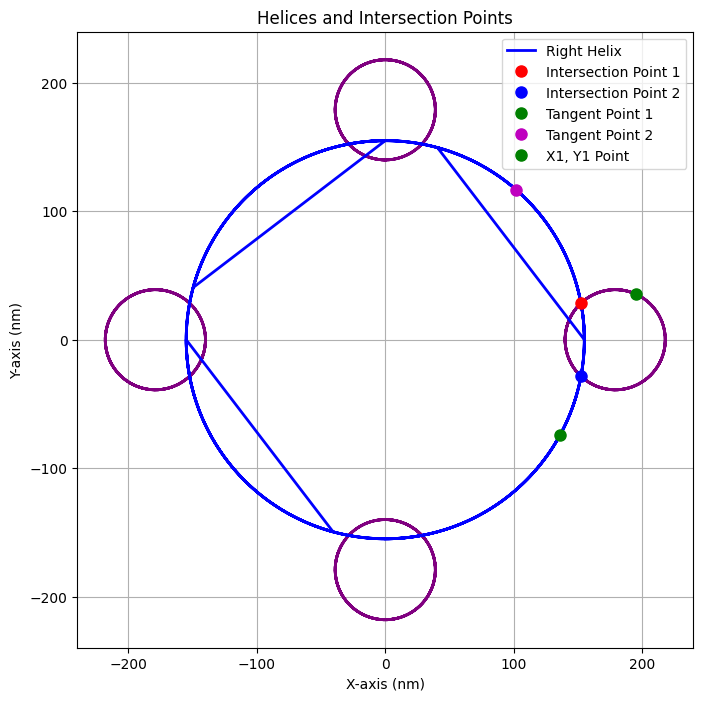

In [59]:
intersections = find_cicles_intersection(
    r1=total_radius_left_helix,
    r2=total_radius_right_helix,
    c1=(d_granum_helix, 0),
    c2=(0, 0)
)

x1, y1 = get_x_y_coordinantes_circle_angle(total_radius_left_helix, c1=(d_granum_helix, 0), angle=65)

tangents = tangent_points_from_circle_point(
    c1=(d_granum_helix, 0), 
    r1=total_radius_left_helix, 
    c2=(0, 0), 
    r2=total_radius_right_helix, 
    point_on_c1=(x1, y1)
)
print("Tangents:", tangents)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
# Plot the left-handed helix
for i in range(len(array_left_outer_helices)):
    helix = array_left_outer_helices[i].points
    ax.plot(helix[:, 0], helix[:, 1], color='purple', linewidth=2, label='Left Helix' if helix is array_left_outer_helices[0] else "")

# Plot the right-handed helix
ax.plot(combined_right_outer_helices.points[:, 0], combined_right_outer_helices.points[:, 1], color='blue', linewidth=2, label='Right Helix')
# Plot the intersection points
ax.plot(intersections[0][0], intersections[0][1], 'ro', markersize=8, label='Intersection Point 1')
ax.plot(intersections[1][0], intersections[1][1], 'bo', markersize=8, label='Intersection Point 2')

# Plot the second tangent points
ax.plot(tangents[0][0], tangents[0][1], 'go', markersize=8, label='Tangent Point 1')
ax.plot(tangents[1][0], tangents[1][1], 'mo', markersize=8, label='Tangent Point 2')

# Plot the x1, y1 point
ax.plot(x1, y1, 'go', markersize=8, label='X1, Y1 Point')
# Set equal aspect ratio
ax.set_aspect('equal', adjustable='box')
# Set labels and title
ax.set_xlabel('X-axis (nm)')
ax.set_ylabel('Y-axis (nm)')
ax.set_title('Helices and Intersection Points')
# Add grid
ax.grid(True)
# Add legend    
ax.legend()
# Show the plot
plt.show()


In [60]:
#right points are higer than intersection 1 y and lower than tangent 2 y and within intersection 1 x and tangent 2 x
right_points = []
print(f"Filtering the points between y: {tangents[1][0]} and {intersections[0][0]}, and x: {intersections[0][1]} and {tangents[1][1]}, and z: 0 to {pitch_left-height_granum*2}")
print(f"Number of right points: {len(combined_right_outer_helices.points)}")

for point in combined_right_outer_helices.points:
    if (point[1] > intersections[0][1] and point[1] < tangents[1][1] and
        point[0] > tangents[1][0] and point[0] < intersections[0][0] and
        point[2] >= 0 and point[2] <= pitch_left/2):
        right_points.append(point)
print(f"Number of right points: {len(right_points)}") 

# The left points are higher than intersection 1 y and lower than y1 and within intersection 1 x and point x1 and z0 and pitch_left
# Move spline 



left_points = []
print(f"Filtering the points between x: {intersections[0][0]} and {x1}, and y: {intersections[0][1]} and {y1} and z: 0 and {pitch_left-height_granum*2}")
for point in array_left_outer_helices[1].points:
    if (point[1] >= intersections[0][1] and point[1] and
        point[0] >= intersections[0][0] and point[0] <= x1 and
        point[2] >= 0 and point[2] <= pitch_left/2):
        left_points.append(point)
print(f"Number of left points: {len(left_points)}")


# Line between x1, y1 and tangent 2 with 10 segments

# Create a line between the points (x1, y1) and tangent 2
# Get right point with the highest z
highest_z_r = max(right_points, key=lambda point: point[2])
lowest_z_r = min(right_points, key=lambda point: point[2])
highest_z_l = max(left_points, key=lambda point: point[2])
dz = highest_z_r[2] - highest_z_l[2]
end_point= [ highest_z_l[0], highest_z_l[1], highest_z_l[2]+dz]
end_to_right = line_between_points(end_point, highest_z_r, n_segments=100)
left_to_end = line_between_points(highest_z_l, end_point, n_segments=100)

print(f"End to right points: {end_point} to {highest_z_r}")


Filtering the points between y: 101.76087150870498 and 152.36033519553072, and x: 28.483824516829216 and 116.91759931588075, and z: 0 to 32.64343459069375
Number of right points: 4004
Number of right points: 109
Filtering the points between x: 152.36033519553072 and 195.48211220788727, and y: 28.483824516829216 and 35.34600369442935 and z: 0 and 32.64343459069375
Number of left points: 49
End to right points: [np.float64(194.71049882075306), np.float64(35.69501230672138), np.float64(31.14)] to [103.87891235 115.03987282  31.14      ]


In [61]:
# Plot right and left points
plot = pv.Plotter(window_size=[1600, 600])
plot.background_color = 'black'
# Plot right points
right_points_mesh = pv.PolyData(right_points)
left_points_mesh = pv.PolyData(left_points)
right_to_end_mesh = pv.PolyData(end_to_right)
left_to_end_mesh = pv.PolyData(left_to_end)

plot.add_mesh(right_points_mesh, color='blue', point_size=10, render_points_as_spheres=True, label='Right Points')
plot.add_mesh(left_points_mesh, color='yellow', point_size=10, render_points_as_spheres=True, label='Left Points')   
plot.add_mesh(right_to_end_mesh, color='green', point_size=10, render_points_as_spheres=True, label='Right to End Line')   
plot.add_mesh(left_to_end_mesh, color='orange', point_size=10, render_points_as_spheres=True, label='Left to End Line')
plot.add_mesh(center_box, color='green', point_size=10, render_points_as_spheres=True, label='Left to End Line',opacity=0.5)

#plot.add_mesh(combined_right_outer_helices, color='light_blue', point_size=10, render_points_as_spheres=True, label='Left to End Line')

# Plot x1 and y1 point
x1_y1_point = pv.PolyData(np.array([[x1, y1, pitch_left - height_granum/2]]))
plot.add_mesh(x1_y1_point, color='red', point_size=10, render_points_as_spheres=True, label='X1, Y1 Point')
# Plot the model 
plot.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False, label='Right Helix')
#plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False, label='Left Helix')
#plot.add_mesh(combined_pitch_boxes, color='green', show_edges=False,opacity=.5, label='Left Helix')
# Plot the splines outer

# Plot the intersection points
# Parallel projection
plot.camera.parallel_projection = True
# Reset view to y-axis
plot.view_xz()
#Rotate view
plot.camera.azimuth = 180
plot.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x126abbdf0_18&reconnect=auto" class="pyvist…

In [62]:
# Plane from loop points
reverse_right_points = np.array(right_points)[::-1]
# Convert to numpy arrays and ensure consistent dimensions
loop = [reverse_right_points, left_points, left_to_end, end_to_right]
#point_arrays = []
#for i in range(len(loop)):
    #loop[i] = np.array(loop[i]) if len(loop[i]) > 0 else np.empty((0, 3))
    
print(f"Loop points: {len(loop[0])} right points, {len(loop[1])} left points, {len(loop[2])} left to end points, {len(loop[3])} right to end points")
# Filter out empty arrays and concatenate
point_arrays = []
for arr in loop:
    point_arrays.append(arr)

loop_points = np.vstack(point_arrays)

# Save the loop points in a dat file
loop_points_path = f"{wdir}/Reference_objs/loop_points.dat"
np.savetxt(loop_points_path, loop_points, fmt='%.6f', header='X Y Z', comments='')
# Remove duplicate points
print(f"Number of loop points before removing duplicates: {len(loop_points)}")
#loop_points = np.unique(loop_points, axis=0)
print(f"Number of loop points after removing duplicates: {len(loop_points)}")

loop_polydata = pv.PolyData(loop_points)


Loop points: 109 right points, 49 left points, 100 left to end points, 100 right to end points
Number of loop points before removing duplicates: 358
Number of loop points after removing duplicates: 358


In [63]:
# Generate edges for the loop points starting from the first point
#edges = [(0,1), (1,2), (2,3), (3,0)]  # a single closed loop
edges = []
for i in range(len(loop_points) - 1):
    edge = (i, i + 1)
    edges.append(edge)
    #print(f"Edge: {edge}")
lines = np.hstack([[2, i, j] for i, j in edges]).astype(np.int64)
#for i in range(len(loop_points) - 1):
    #print(f"Edge {i}: {loop_points[i]} to {loop_points[i + 1]}")
# Create a PolyData object for the loop
loop_polydata = pv.PolyData(loop_points, lines=lines)

#for line in loop_polydata.lines:
#    print(f"Line: {line}")

In [64]:
# First, ensure the loop is properly closed and oriented
try:
	# Try delaunay triangulation
	triangulated_loop = loop_polydata.delaunay_2d()
	print(f"Delaunay triangulation successful. Triangulated mesh has {triangulated_loop.n_faces} faces.")
except Exception as e:
	print(f"Delaunay triangulation failed: {e}")
	# Fall back to a simple approach - create a convex hull or use alternative triangulation
	triangulated_loop = loop_polydata.triangulate()

# Extrude the triangulated surface
extruded_loop = triangulated_loop.extrude([0, 0, height_granum], capping=True)


# Clean the mesh to remove duplicate points and fix mesh issues
extruded_loop = extruded_loop.clean()

# Save the extruded loop mesh
extruded_loop_path = f"{wdir}/models/extruded_loop.obj"
extruded_loop.save(extruded_loop_path)
print(f"Extruded loop mesh saved to: {extruded_loop_path}")
        

Delaunay triangulation successful. Triangulated mesh has 383 faces.
Extruded loop mesh saved to: /Users/rubi/Documents/GitHub/Chloroplast/models/extruded_loop.obj


In [65]:
plot = pv.Plotter(window_size=[1600, 600])
plot.background_color = 'white'
# Add the surface mesh
plot.add_mesh(extruded_loop, color='lightblue', show_edges=True, label='Loop Surface')
plot.show()

Widget(value='<iframe src="http://localhost:49423/index.html?ui=P_0x1269578b0_19&reconnect=auto" class="pyvist…

In [66]:
#Subdivide 
loop_poly = loop_poly.subdivide(8)  # Increase the number of points in the surface

avg_area, std_area = mesh_resolution(loop_poly)
print(avg_area)
clus = pyacvd.Clustering(loop_poly)
clus.cluster(10000)
avg_area, std_area = mesh_resolution(loop_poly)

remesh = clus.create_mesh()
avg_area, std_area = mesh_resolution(remesh)

NameError: name 'loop_poly' is not defined

In [ ]:
# Plot right and left points
plot = pv.Plotter(window_size=[1600, 600])
plot.background_color = 'white'
# Plot right points
right_points_mesh = pv.PolyData(right_points)
left_points_mesh = pv.PolyData(left_points)
right_to_end_mesh = pv.PolyData(end_to_right)
left_to_end_mesh = pv.PolyData(left_to_end)

plot.add_mesh(extruded_hills, color='lightblue', show_edges=True, label='Extruded Hills')
plot.add_mesh(right_points_mesh, color='blue', point_size=10, render_points_as_spheres=True, label='Right Points')
plot.add_mesh(left_points_mesh, color='yellow', point_size=10, render_points_as_spheres=True, label='Left Points')   
plot.add_mesh(right_to_end_mesh, color='green', point_size=10, render_points_as_spheres=True, label='Right to End Line')   
plot.add_mesh(left_to_end_mesh, color='orange', point_size=10, render_points_as_spheres=True, label='Left to End Line')
#plot.add_mesh(center_box, color='green', point_size=10, render_points_as_spheres=True, label='Left to End Line')

# Plot the intersection points
# Parallel projection
plot.camera.parallel_projection = True
# Reset view to y-axis
plot.view_xz()
#Rotate view
plot.camera.azimuth = 180
plot.show()

In [ ]:
edge_1_to_1 = line_between_points(end_point, (end_point[0], end_point[1], end_point[2] + height_granum), n_segments=100)
edge_2_to_2 = line_between_points(highest_z_l, (highest_z_l[0], highest_z_l[1], highest_z_l[2] + height_granum), n_segments=100)
edge_3_to_3 = line_between_points(lowest_z_r, (lowest_z_r[0], lowest_z_r[1], lowest_z_r[2] + height_granum), n_segments=100)
edge_4_to_4 = line_between_points(highest_z_r, (highest_z_r[0], highest_z_r[1], highest_z_r[2] + height_granum), n_segments=100)

edge_4_to_3 = np.array(reverse_right_points)
edge_3_to_2 = np.array(left_points)
edge_2_to_1 = np.array(left_to_end)
edge_1_to_4 = np.array(end_to_right)


# Create copies and increase z direction by height_granum
edge_1_to_4_ = edge_1_to_4.copy()
edge_3_to_2_ = edge_3_to_2.copy()
edge_4_to_3_ = edge_4_to_3.copy()
edge_2_to_1_ = edge_2_to_1.copy()
edge_1_to_4_[:, 2] += height_granum
edge_3_to_2_[:, 2] += height_granum
edge_4_to_3_[:, 2] += height_granum
edge_2_to_1_[:, 2] += height_granum

edge_1_to_1_reverse = np.array(edge_1_to_1[::-1])
edge_2_to_2_reverse = np.array(edge_2_to_2[::-1])
edge_3_to_3_reverse = np.array(edge_3_to_3[::-1])
edge_4_to_4_reverse = np.array(edge_4_to_4[::-1])
edge_1_to_4_reverse = np.array(edge_1_to_4_[::-1])
edge_3_to_2_reverse = np.array(edge_3_to_2_[::-1])
edge_4_to_3_reverse = np.array(edge_4_to_3_[::-1])
edge_2_to_1_reverse = np.array(edge_2_to_1_[::-1])

# Combine all points into a single array for creating the PolyData
all_points = []
face_1_4_3_2 = np.vstack((edge_1_to_4, edge_4_to_3, edge_3_to_2, edge_2_to_1))
face_1_4_3_2_ = np.vstack((edge_1_to_4_, edge_4_to_3_, edge_3_to_2_, edge_2_to_1_))
face_1_2_2_1 = np.vstack((edge_2_to_1, edge_1_to_1, edge_2_to_1_reverse, edge_2_to_2_reverse))
face_1_4_4_1 = np.vstack((edge_1_to_4, edge_4_to_4, edge_1_to_4_reverse, edge_1_to_1_reverse))#
face_2_3_3_2 = np.vstack((edge_3_to_2, edge_2_to_2, edge_3_to_2_reverse, edge_3_to_3_reverse))
face_3_4_4_3 = np.vstack((edge_4_to_3, edge_3_to_3, edge_4_to_3_reverse, edge_4_to_4_reverse))#

face_arrays = [
    face_1_4_3_2,
    face_1_4_3_2_,
    face_1_2_2_1,
    face_1_4_4_1,
    face_2_3_3_2,
    face_3_4_4_3
]

face_poly = []
for face in face_arrays:
    # Create a PolyData object for each face
    face_poly_data = pv.PolyData(face)
    # Append the face PolyData to the list
    face_poly.append(face_poly_data)

#for point in edge_1_to_1:
#    print(f"Point 1 to 1: {point}")

face_poly =  pv.PolyData(face_arrays[0]).delaunay_2d()  # Initialize with the first face
for face in face_arrays[1:]:
    # Create a PolyData object for each face
    face_poly_data = pv.PolyData(face).delaunay_2d()
    # Simply combine the meshes using the + operator
    face_poly += face_poly_data
    print(f"Number of points in the face_poly_data: {face_poly_data.n_points}")


print(f"Number of points in the face_poly: {face_poly.n_points}")
## Create a closed surface from the face points
face_poly.clean()  # Clean the PolyData to remove any duplicate points or cells
print(f"Number of points after cleaning: {face_poly.n_points}")
#
## Remove duplicate points
#face_poly.points = np.unique(face_poly.points, axis=0)
#print(f"Number of points after removing duplicates: {face_poly.n_points}")
#
## Total points in the face_array
#total_points = sum([len(face) for face in face_arrays])
#print(f"Total points in the face_arrays: {total_points}")

In [ ]:
#remesh = face_poly.subdivide(2)  # Increase the number of points in the surface


In [ ]:
# Uniform faces
#CCluster the mesh with pyacvd
clus = pyacvd.Clustering(face_poly).subdivide(2)  # Increase the number of points in the surface
print(f"Number of points in the remesh before clustering: {remesh.n_points}")
clus.cluster(10000)
remesh = clus.create_mesh()


In [ ]:
plot = pv.Plotter(window_size=[1600, 600])
plot.background_color = 'white'
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta']


#edge_1 = pv.PolyData(edge_2_to_1)
#edge_2 =  pv.PolyData(edge_1_to_1)
#edge_3 = pv.PolyData(edge_2_to_1_)
#edge_4 = pv.PolyData(edge_2_to_2_)
#
#plot.add_mesh(edge_1, color='r', point_size=10, render_points_as_spheres=True, label='Edge 4 to 4')
#plot.add_mesh(edge_2, color='g', point_size=10, render_points_as_spheres=True, label='Edge 4 to 4 (height_granum)')
#plot.add_mesh(edge_3, color='b', point_size=10, render_points_as_spheres=True, label='Edge 3 to 4')
#plot.add_mesh(edge_4, color='y', point_size=10, render_points_as_spheres=True, label='Edge 3 to 4 (height_granum)')
# Add the face mesh
plot.add_mesh(face_poly, color='r', show_edges=True, opacity=1, label='Face Poly')

#plot.add_mesh(face_poly[0], color='r', show_edges=True, opacity=1, label='Face Poly')
#plot.add_mesh(face_poly[1], color='g')
#plot.add_mesh(face_poly[2], color='b')
#plot.add_mesh(face_poly[3], color='y')
#plot.add_mesh(face_poly[4], color='c')
#plot.add_mesh(face_poly[5], color='m')
plot.show()

In [ ]:
break

In [ ]:
margin = height_granum*2/10 # Magic number, might not be needed with a higher resolution mesh

# Rotate mesh along the z-axis
connectors_down_ul = remesh.copy()
rotations = [90,180,270]
for rot in rotations:
    copy = remesh.copy()
    connectors_down_ul += copy.rotate_z(rot, inplace=True)
connectors_down_ll = remesh.copy()
connectors_down_ll.points[:, 2] += height_granum
for rot in rotations:
    copy = remesh.copy()
    copy.points[:, 2] += height_granum  

    connectors_down_ll += copy.rotate_z(rot, inplace=True)
# Remove the last margin points in the z-direction
print(f"Max z value before applying limit: {connectors_down_ll.points[:, 2].max()}")
z_max_limit = connectors_down_ll.points[:, 2].max() - margin
connectors_down_ll.points[:, 2] = np.where(connectors_down_ll.points[:, 2] > z_max_limit, z_max_limit, connectors_down_ll.points[:, 2])
print(f"Max z value after applying limit: {connectors_down_ll.points[:, 2].max()}")


connectors_up = remesh.copy()
connectors_up.rotate_x(180, inplace=True)
# Translate the points in the z direction
connectors_up.points[:, 2] += pitch_left + height_granum - margin 

connectors_up_ul = connectors_up.copy()
connectors_up_ul_array = connectors_up_ul.copy()

for rot in rotations:
    copy = connectors_up.copy()
    connectors_up_ul += copy.rotate_z(rot, inplace=True)

connectors_up_ll = connectors_up.copy()
connectors_up_ll.points[:, 2] -= height_granum 
connectors_up_ll_array = connectors_up_ll.copy()
for rot in rotations:
    copy = connectors_up.copy()
    copy.points[:, 2] -= height_granum  
    connectors_up_ll += copy.rotate_z(rot, inplace=True)

merge_test = connectors_up_ul_array + connectors_up_ll_array
merge_test = merge_test.fill_holes(1000, inplace=True)  # Fill holes in the mesh
merge_test = merge_test.triangulate(inplace=True)  # Triangulate the mesh

# Remove the last margin points in the z-direction
print(f"Min z value before applying limit: {connectors_up_ll.points[:, 2].min()}")
z_min_limit = connectors_up_ll.points[:, 2].min() + margin
connectors_up_ll.points[:, 2] = np.where(connectors_up_ll.points[:, 2] < z_min_limit, z_min_limit, connectors_up_ll.points[:, 2])
print(f"Min z value after applying limit: {connectors_up_ll.points[:, 2].min()}")


## Connectors

In [ ]:
# Create a Plotter object for the loop
loop_plot = pv.Plotter(window_size=[1200, 800])
loop_plot.background_color = 'black'
# Add the triangulated loop mesh
#loop_plot.add_mesh(remesh, color='cyan', show_edges=True, line_width=2, opacity=1)
#loop_plot.add_mesh(connectors_down_ll, color='orange', show_edges=False, line_width=2, opacity=1)
#loop_plot.add_mesh(connectors_down_ul, color='cyan', show_edges=False, line_width=2, opacity=1)
#loop_plot.add_mesh(connectors_up_ll, color='orange', show_edges=False, line_width=2, opacity=1)
#loop_plot.add_mesh(connectors_up_ul, color='cyan', show_edges=False, line_width=2, opacity=1)
loop_plot.add_mesh(merge_test, color='cyan', show_edges=False, line_width=2, opacity=1)

#loop_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)
#loop_plot.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False)
loop_plot.add_mesh(center_box, color='green', show_edges=False, opacity=0.5)


#Plot point at  0,0
#loop_plot.add_mesh(pv.PolyData([[0, 0, 0]]), color='red', point_size=10, render_points_as_spheres=True, label='Center Point')
#loop_plot.add_mesh(combined_pitch_boxes, color='green', show_edges=False, opacity=1)
#loop_plot.add_mesh(box, color='green', show_edges=False, opacity=0.5)

# Plot points right and left points
#loop_plot.add_mesh(right_points_mesh, color='blue', point_size=10, render_points_as_spheres=True, label='Right Points')
#loop_plot.add_mesh(left_points_mesh, color='yellow', point_size=10, render_points_as_spheres=True, label='Left Points')   
#loop_plot.add_mesh(right_to_end_mesh, color='green', point_size=10, render_points_as_spheres=True, label='Right to End Line')   
#loop_plot.add_mesh(left_to_end_mesh, color='orange', point_size=10, render_points_as_spheres=True, label='Left to End Line')


loop_plot.view_yz()
#Paralle projection
loop_plot.camera.parallel_projection = True
# Add the left and right points
# Show axes and origin
loop_plot.show_axes()
# Show the plot
loop_plot.show()

## Merging the connectors with the planes

In [ ]:
REWRITE_PLANES = True
if REWRITE_PLANES:
    #save = [loop_polydata,center_box]
    #offset = 5
    #for i, model in enumerate(save):
    #    print(f"Saving model {i+1+offset}...")
    #    model.save(f"{wdir}/models/model_{i+1+offset}.obj")
    #command = "python3 scripts/boolean_meshes.py -type union -f models/model_1.obj models/model_2.obj models/model_3.obj models/model_4.obj models/model_5.obj -o models/merged_planes.obj -ids 2 3 3 3 3"
    command = "python3 scripts/boolean_meshes.py -type difference -f models/extruded_loop.obj models/model_7.obj -o models/merged_planes.obj -ids 2 3 "

    result = os.system(command)
    if result == 0:
        print("MODELS MERGED SUCCESFULLY.")
    else:
        print("Error merging models.")
        print("Check the input files and try again.")

Saving model 6...
Saving model 7...
Merging 2 models...
Loaded: models/extruded_loop.obj (4272 pts, 1422 cells with ID 2)
Loaded: models/model_7.obj (378008 pts, 378006 cells with ID 3)
Starting with model 1: 4272 points
Merging model 2...
ERROR merging model 2 with type union: Make sure both the input and output are triangulated.
Maybe the models are too complex for PyVista :(
You could try cleaning or triangulating your system with Pyvista beforehand.
Union may fail if models are not manifold or have complex geometry.
Error merging models.
Check the input files and try again.


In [ ]:
#%pip install networkx

# Read the meshes
mesh_1 = trimesh.load_mesh("models/extruded_loop.obj")
mesh_2 = trimesh.load_mesh("models/model_7.obj")

# Check if meshes are watertight and fix them if needed
if not mesh_1.is_watertight:
	print("Mesh 1 is not watertight, attempting to fix...")
	mesh_1.fill_holes()
	mesh_1.fix_normals()
	if not mesh_1.is_watertight:
		print("Warning: Could not make mesh 1 watertight")
else:
	print("Mesh 1 is watertight")

if not mesh_2.is_watertight:
	print("Mesh 2 is not watertight, attempting to fix...")
	mesh_2.fill_holes()
	mesh_2.fix_normals()
	if not mesh_2.is_watertight:
		print("Warning: Could not make mesh 2 watertight")
else:
	print("Mesh 2 is watertight")

# Perform the boolean operation
try:
	intersection = mesh_1.union(mesh_2)
	print("Boolean union successful")
except Exception as e:
	print(f"Boolean operation failed: {e}")
	# Alternative: just combine the meshes without boolean operation
	intersection = mesh_1 + mesh_2
	print("Fallback: Combined meshes without boolean operation")

Mesh 1 is watertight
Mesh 2 is watertight
Boolean operation failed: Not all meshes are volumes!
Fallback: Combined meshes without boolean operation


In [ ]:
# Union with pymeshlab
# Load the meshes into PyMeshLab
import pymeshlab
ms = pymeshlab.MeshSet()
ms.load_new_mesh("models/extruded_loop.obj")
ms.load_new_mesh("models/model_7.obj")

# Perform the union operation using the correct method name
ms.generate_boolean_union(first_mesh=0, second_mesh=1)

# Save the result
ms.save_current_mesh("models/union_result.obj")


In [ ]:
import meshlib.mrmeshpy as mr
# Load the meshes using mrmeshpy
cube = mr.loadMesh("models/model_6.obj")
torus = mr.loadMesh("models/model_7.obj")
# compute the difference between the cube and the torus:
diff = mr.boolean( cube, torus, mr.BooleanOperation.DifferenceAB )
# Print the number of vertices and faces in the resulting mesh:
print(f"Number of vertices in the difference mesh: {diff.mesh.points.size()}")
print(f"Number of faces in the difference mesh: {diff.mesh.topology.numValidFaces()}")
# save the difference in file:
mr.saveMesh(diff.mesh, "diff.obj")

In [ ]:
break 

# 🟠 Merging the helices

### Removing left-handed helices regions that are not part of the model

In [ ]:
# Add material labels to keep track of the regions
for i, helix in enumerate(right_helix_4):
    add_material_labels(helix, material_id=1, color_name='blue')

for i, helix in enumerate(left_helix_4):
    add_material_labels(helix, material_id=2, color_name='purple')

combined_left_handed_helices = add_material_labels(combined_left_handed_helices, material_id=2, color_name='purple')

### Remove the regions were the left-handed helices intersect with the right-handed helices

In [ ]:
break 

### Merging the left-handed helices with the right-handed helices

In [ ]:
merged_helices = combined_left_handed_helices.boolean_union(right_helix_4[0])  # Start with the first helices
#merged_helices = merged_helices.boolean_union(right_helix_4[1])  # Union with the second right-handed helix
#merged_helices = merged_helices.boolean_union(right_helix_4[2])  # Union with the third right-handed helix
#merged_helices = merged_helices.boolean_union(right_helix_4[3])  # Union with the fourth right-handed helix

In [ ]:
#Plot only a specific material
# Extract only the blue material (material_id == 1)
right_merged = merged_helices.cell_data['material_id'] == 1
right_merged = merged_helices.extract_cells(right_merged)

left_merged = merged_helices.cell_data['material_id'] == 2
left_merged = merged_helices.extract_cells(left_merged)

plot_combined_helices_blue = pv.Plotter(window_size=[1800, 600])
plot_combined_helices_blue.background_color = 'white'
plot_combined_helices_blue.add_mesh(left_merged, color='purple', show_edges=True,
                        show_scalar_bar=False,
                        opacity=1)
plot_combined_helices_blue.add_mesh(right_merged, color='lightblue', show_edges=True,
                        show_scalar_bar=False,
                        opacity=1)
#plot_combined_helices_blue.add_mesh(right_merged, color='lightblue', show_edges=True,show_scalar_bar=False,opacity=1)
plot_combined_helices_blue.show()

### Separate the left-handed helices by loose part and then classify by size


In [ ]:
from sklearn.cluster import KMeans
import pyvista as pv

def classify_kmeans(array, n_groups=2):
    """
    Classify an array into n_groups using KMeans clustering.
    
    Parameters:
    array (array-like): The input array to classify. Must support .astype() and .reshape() methods. e..g., a numpy array.
    n_groups (int): The number of groups to classify into.

    Returns:
    np.ndarray: The labels assigned to each element in the input array.
    """
    # Check if the array can be converted to a numeric type
    try:
        values = array.astype(float)
    except ValueError:
        print(f"Array: {array}")
        raise ValueError(f"Array cannot be converted to a numeric type.")

    # Cluster the values into n_groups using KMeans
    kmeans = KMeans(n_clusters=n_groups, random_state=0)
    kmeans.fit(values.reshape(-1, 1))
    labels = kmeans.labels_
    return labels

def classify_mesh_array_attribute(mesh_array, attribute_name='volume', n_groups=2):
    """
    Classify a mesh array into n_groups using KMeans clustering based on a specified attribute.
    
    Parameters:
    mesh_array (list of pyvista.PolyData): The input mesh array to classify.
    attribute_name (str): The name of the attribute to use for classification, compatible with pyvista e.g., 'volume', 'area', etc.
    n_groups (int): The number of groups to classify into.

    Returns:
    list: A list of labels assigned to each mesh in the input array.
    """
    # Extract the attribute values from all meshes
    try:
        attribute_values = np.array([getattr(mesh, attribute_name, None) for mesh in mesh_array])
        attribute_values = attribute_values[~np.isnan(attribute_values)]  # Remove NaN values
    except Exception as e:
        raise ValueError(f"The attribute must be a numeric type compatible with KMeans. Error: {e}")
    
    # Check if we have valid attribute values
    if len(attribute_values) == 0:
        raise ValueError(f"No valid attribute values found for '{attribute_name}'.")
    
    # Print statistics of the attribute values
    print(f"Attribute '{attribute_name}' statistics:")
    print(f"  Min: {attribute_values.min()}")
    print(f"  Max: {attribute_values.max()}")
    print(f"  Mean: {attribute_values.mean()}")
    print(f"  Std: {attribute_values.std()}")
    
    # Classify the attribute values using KMeans
    labels = classify_kmeans(attribute_values, n_groups=n_groups)

    # Convert labels to a numpy array for consistency
    labels = np.array(labels)

    # Assign the labels back to the meshes


    for mesh, label in zip(mesh_array, labels):
        mesh[attribute_name] = np.full(mesh.n_cells, label)
    
    return mesh_array, labels



def classify_mesh_array_attribute(mesh_array, values_array, attribute_name='cluster', n_groups=2):
    """
    Classify a mesh array into n_groups using KMeans clustering based on a specified attribute.
    
    Parameters:
    mesh_array (list of pyvista.PolyData): The input mesh array to classify.
    values_array (np.ndarray): The array of values to use for classification.
    n_groups (int): The number of groups to classify into.

    Returns:
    list: A list of labels assigned to each mesh in the input array.
    """
    # Check if the length of values_array matches the number of meshes
    if len(values_array) != len(mesh_array):
        raise ValueError("The length of values_array must match the number of meshes in mesh_array.")
    
    # Print statistics of values_array
    print(f"Values array statistics:")
    print(f"  Min: {values_array.min()}")
    print(f"  Max: {values_array.max()}")
    print(f"  Mean: {values_array.mean()}")
    print(f"  Std: {values_array.std()}")

    
    # Classify the attribute values using KMeans
    labels = classify_kmeans(values_array, n_groups=n_groups)

    # Convert labels to a numpy array for consistency
    labels = np.array(labels)

    # Assign the labels back to the meshes
    for mesh, label in zip(mesh_array, labels):
        mesh[attribute_name] = np.full(mesh.n_cells, label)

    return mesh_array, labels

In [ ]:
# Assign index to the original mesh to keep track
combined_merged_helices = add_cell_index_labels(merged_helices)

#print the first 10 indices
print("First 10 indices of the combined merged helices:")
print(combined_merged_helices.cell_data['index'][:10])


left_merged = combined_merged_helices.cell_data['material_id'] == 2
left_merged = combined_merged_helices.extract_cells(left_merged)

# print the first 10 indices of the left merged helices
print("First 10 indices of the left merged helices:")
print(left_merged.cell_data['index'][:10])
#--- split_bodies() to separate loose bodies
split_bodies = left_merged.split_bodies()

# Convert the unstructured grid to a PolyData object
split_bodies = [body.extract_surface() for body in split_bodies if body.n_cells > 0]
split_bodies = [body for body in split_bodies if body.n_faces > 0]
print(f"First 10 indices of the split bodies:")
for i, body in enumerate(split_bodies[:10]):
    print(f"Body {i}: {body.cell_data['index'][:10]}")
# Bodies centers
centers = [body.center for body in split_bodies]
centers_x_y = [[center[0], center[1]] for center in centers]

# Distance to the z axis
abs_centers_x = np.abs(np.array(centers_x_y)[:, 0])
abs_centers_y = np.abs(np.array(centers_x_y)[:, 1])
# Calculate the distance from the z-axis
abs_centers = np.sqrt(abs_centers_x**2 + abs_centers_y**2)




# Classify in n groups by volume
n_groups = 2  # Number of groups to classify into
attribute_name = 'distance'  # Attribute to classify by, e.g., 'volume', 'area', etc.

# Classify the bodies based on their distances
split_bodies, labels = classify_mesh_array_attribute(split_bodies, abs_centers, attribute_name=attribute_name, n_groups=n_groups)

#---INFO---
# Print the number of meshes in each group
for i in range(n_groups):
    count = sum(1 for mesh in split_bodies if np.any(mesh[attribute_name] == i))
    print(f"Group {i}: {count} meshes")
    
# Merge the classified bodies into a single mesh
merged_bodies = split_bodies[0].copy()
for body in split_bodies[1:]:
    merged_bodies += body

In [ ]:
# Plot the classified meshes
#colors = ['red', 'green', 'blue', 'yellow']  # Define colors for each group
#colors = ['red', 'green', 'blue']  # Define colors for each group
colors = ['red', 'green']  # Define colors for each group
plot_classified_meshes = pv.Plotter(window_size=[1800, 600])
plot_classified_meshes.background_color = 'black'
plot_classified_meshes.add_mesh(merged_bodies, scalars=attribute_name,
                                 cmap=colors, show_edges=False,
                                 opacity=1, scalar_bar_args={'title': 'Distance to Z-axis'})
# Add right-handed 
plot_classified_meshes.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False, opacity=0.5)

plot_classified_meshes.show_axes()
plot_classified_meshes.show()

In [ ]:
# Print material IDs and colors
unique_material_ids = np.unique(merged_bodies.cell_data['distance'])  # Assuming 'distance' is the attribute used for classification
material_colors = ['purple', 'lightblue', 'orange']  # Define colors for each material ID

for mat_id, color in zip(unique_material_ids, material_colors):
    print(f"Material ID: {mat_id}, Color: {color}")


# Print the number of cells in each material
for mat_id in unique_material_ids:
    count = np.sum(merged_bodies.cell_data['distance'] == mat_id)
    print(f"Material ID: {mat_id}, Number of cells: {count}")


In [ ]:
# Get the indices of the classified meshes
ids = [] 

left_merged = merged_bodies.cell_data['distance'] == 0
ids = merged_bodies.extract_cells(left_merged).cell_data['index'].tolist()

#for body in split_bodies:
#    if body.n_cells > 0:
#        id = body.cell_data['index']
#        material_id = body.cell_data['distance']
#        ids.extend(id)  # Extend the list with the indices of the cells
#
## Convert ids to a numpy array
#ids = np.array(ids)



#merged_bodies.cell_data['material_id'] == 0
#cell_indices_group_0 = merged_bodies.extract_cells(ids)
#ids = cell_indices_group_0.cell_data['index']

print("First 10 indices of the group 0 cells:")
print(ids[:10])
# Assign material_id 3 indices in the original mesh
# Create boolean mask for cells that are in ids
mask = np.isin(combined_merged_helices.cell_data['index'], ids)
# Apply material_id to matching cells
combined_merged_helices.cell_data['material_id'][mask] = 3


In [ ]:
# Print unique material IDs after classification
unique_material_ids_after = np.unique(combined_merged_helices.cell_data['material_id'])
print(f"Unique material IDs after classification: {unique_material_ids_after}")

In [ ]:
# Remove all the cells with material_id 3
print(f"Total number of cells before filtering: {combined_merged_helices.n_cells}")
mask = combined_merged_helices.cell_data['material_id'] != 3 
filtered_combined_helices = combined_merged_helices.extract_cells(mask)
print(f"Total number of cells after filtering: {filtered_combined_helices.n_cells}")

# Print the unique materials
unique_materials = np.unique(filtered_combined_helices.cell_data['material_id'])
print(f"Unique materials after filtering: {unique_materials}")

In [ ]:
# Fill holes in the mesh
filled_mesh = filtered_combined_helices.fill_holes(5000)  # Fill holes smaller than 1000 nm^2

In [ ]:
# Plot the classified meshes
plot_intersecting_meshes = pv.Plotter(window_size=[1800, 600])
plot_intersecting_meshes.background_color = 'white'

plot_intersecting_meshes.add_mesh(filled_mesh, show_edges=True)
# Add right-handed helices
# plot_intersecting_meshes.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False, opacity=0.5)

plot_intersecting_meshes.show_axes()
plot_intersecting_meshes.show()

In [ ]:
# The meshes that we want to keep are in the second group (index 1)
filtered_meshes = [mesh for mesh in split_bodies if np.any(mesh[attribute_name] == 1)]

# Combine the filtered meshes into a single mesh
#combined_filtered_mesh = filtered_meshes[0].copy()
#for mesh in filtered_meshes[1:]:
#    combined_filtered_mesh += mesh
#
## Plot the combined filtered mesh
#plot_combined_filtered = pv.Plotter(window_size=[1800, 600])
#plot_combined_filtered.background_color = 'black'
#plot_combined_filtered.add_mesh(combined_filtered_mesh, color='purple', show_edges=False)
##plot_combined_filtered.add_mesh(combined_right_handed_helices, color='lightblue', show_edges=False, opacity=1)
#plot_combined_filtered.show_axes()
#plot_combined_filtered.show()

## Merging with the right-handed helices



In [ ]:
#Check how many meshes intercept with the right-handed helices
intersecting_meshes = []
for mesh in filtered_meshes:
    collision_result = mesh.collision(right_helix_4[0])
    if collision_result[0].n_cells > 0:  # If there are collision cells, meshes intersect
        intersecting_meshes.append(mesh)

print(f"Number of meshes that intersect with the right-handed helices: {len(intersecting_meshes)}")

In [ ]:
merged_helices = combined_filtered_mesh.boolean_union(right_helix_4[0])  # Start with the first helices
merged_helices = merged_helices.boolean_union(right_helix_4[1])  # Union with the second right-handed helix
merged_helices = merged_helices.boolean_union(right_helix_4[2])  # Union with the third right-handed helix
merged_helices = merged_helices.boolean_union(right_helix_4[3])  # Union with the fourth right-handed helix

In [ ]:
# Add material to combined left-handed helices
combined_right_handed_helices = add_material_labels(combined_right_handed_helices, material_id=1, color_name='blue')
combined_left_handed_helices = add_material_labels(combined_left_handed_helices, material_id=2, color_name='purple')

combined_helices = combined_left_handed_helices.boolean_union(right_helix_4[0])  # Start with the first helices
combined_helices = combined_helices.boolean_union(right_helix_4[1])  # Union with the second right-handed helix
combined_helices = combined_helices.boolean_union(right_helix_4[2])  # Union with the third right-handed helix

In [ ]:
# Add material labels
for i, helix in enumerate(right_helix_4):
    add_material_labels(helix, material_id=1, color_name='blue')

for i, helix in enumerate(left_helix_4):
    add_material_labels(helix, material_id=2, color_name='purple')

#combined_right_handed_helices = combined_right_handed_helices.clean().fill_holes(1000)  # Clean the mesh to remove duplicate points
#combined_left_handed_helices = combined_left_handed_helices.clean().fill_holes(1000)  # Clean the

# Add material to combined left-handed helices
combined_right_handed_helices = add_material_labels(combined_right_handed_helices, material_id=1, color_name='blue')
combined_left_handed_helices = add_material_labels(combined_left_handed_helices, material_id=2, color_name='purple')

combined_helices = combined_left_handed_helices.boolean_union(right_helix_4[0])  # Start with the first helices
combined_helices = combined_helices.boolean_union(right_helix_4[1])  # Union with the second right-handed helix
combined_helices = combined_helices.boolean_union(right_helix_4[2])  # Union with the third right-handed helix




# 🟡 CONE: Connect the right-handed helices

In [ ]:
array_cone_centers_plus = np.array(cone_centers_plus)
array_cone_centers_minus = np.array(cone_centers_minus)
# Create cones at the calculated centers
cones_plus = []
cones_minus = []
for center_plus, center_minus in zip(array_cone_centers_plus, array_cone_centers_minus):
    cone_plus = mesh2.copy()
    cone_plus.points += np.array(center_plus) - cone_plus.center  # Translate to the new center
    cones_plus.append(cone_plus)

    cone_minus = mesh2.copy()
    cone_minus.points += np.array(center_minus) - cone_minus.center  # Translate to the new center
    cones_minus.append(cone_minus)

# Combine all cones into a single mesh
combined_cones = cones_plus[0]
for cone in cones_plus[1:]:
    combined_cones += cone
for cone in cones_minus[1:]:
    combined_cones += cone



# Model

In [ ]:


#pitch_positions = np.linspace(point_0[2]+(pitch_left/2), pitch_left*6.5, int(n_turns_left_helix + 1))




#Generate a box in the pitch positions with the same width as the helix
pitch_boxes = []
for z in pitch_positions:
    box = pv.Cube(center=(0, 0, z), x_length=500, y_length=500, z_length=20)
    # Rotate 45 degrees around the z-axis
    box.rotate_z(45, inplace=True)

    pitch_boxes.append(box)
# Combine the pitch boxes into a single mesh
combined_pitch_boxes = pitch_boxes[0].copy()
for box in pitch_boxes[1:]:
    combined_pitch_boxes += box

#--- Plot the left-handed helix 
left_helix_plot = pv.Plotter(window_size=[1800, 1600])
left_helix_plot.background_color = 'black'

# Change orthographic projection to view the helix from the side
left_helix_plot.camera.parallel_projection = True

#left_helix_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)

left_helix_plot.add_mesh(combined_right_handed_helices, color='light_blue', show_edges=False)
left_helix_plot.add_mesh(left_helix_4[0], color='purple', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[1], color='light_blue', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[2], color='light_blue', show_edges=False)
#left_helix_plot.add_mesh(left_helix_4[3], color='light_blue', show_edges=False)
#
#left_helix_plot.add_mesh(combined_cones, color='orange', show_edges=False)
#right_helix_plot.add_mesh(reference_right_helix, color='blue', show_edges=False)
#left_helix_plot.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
#left_helix_plot.add_mesh(combined_right_handed_helices_big, color='green', show_edges=False)
#Plot the pitch boxes
#left_helix_plot.add_mesh(combined_pitch_boxes, color='green', show_edges=False, opacity=0.5)

left_helix_plot.show()


## Second periodic model: Grana and helices

In [ ]:
#Filter the points that are within zi and zf
# Get cell centers directly using PyVista's method
cell_centers = combined_grana_cylinders.cell_centers().points

# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi 
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_grana = combined_grana_cylinders.extract_cells(cell_ind)

# Subgrid right-handed helicesS
cell_centers = combined_right_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_right_helices = combined_right_handed_helices.extract_cells(cell_ind)

# Subgrid left-handed helices
cell_centers = combined_left_handed_helices.cell_centers().points
# Create mask for cells with z-coordinate > zi
mask = cell_centers[:, 2] > zi
mask &= cell_centers[:, 2] < zf  # Also check if z-coordinate < zf
cell_ind = mask.nonzero()[0]
subgrid_left_helices = combined_left_handed_helices.extract_cells(cell_ind)

# Plot 3 copies
periodic_grana_plot = pv.Plotter(window_size=[1800, 600])
periodic_grana_plot.background_color = 'white'
periodic_grana_plot.add_mesh(subgrid_grana, color='yellow', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_right_helices, color='blue', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.add_mesh(subgrid_left_helices, color='purple', point_size=5, render_points_as_spheres=True)
periodic_grana_plot.show()


## Flat stroma lamellae

In [ ]:
# Single plane center at zero
#single_plane = pv.Plane(center=(0, 0, 0), direction=(0, 0, 1), i_size=400, j_size=400).triangulate()

#Rotate 45 degrees around the z-axis
#single_plane.rotate_z(45, inplace=True)
#second_plane = single_plane.copy()
# Translate the second plane to the z position of the stacks
#dz = -height_granum 
#second_plane.points += np.array([0, 0, dz])
side = 250
side2 = 500

box = pv.Box(bounds=(-side2, side2, -side2, side2, -height_granum, height_granum), level=int(side2/10)).triangulate()
box = box.rotate_z(45, inplace=True)
box.points += np.array([0, 0, -10])  # Center the box at the origin
second_box = box.copy()
# Translate the second box to the z position of the stacks
dz = 50
second_box.points += np.array([0, 0, dz])
#Rotate 45 degrees around the z-axis
#box = box.rotate_z(45, inplace=True)

third_box = pv.Box(bounds=(-45, side,-45, side, -height_granum+8, height_granum+8), level=int(side/10))
# Rotate 30 degrees around the x-axis
third_box.rotate_x(10, inplace=True)

fourth_box = pv.Box(bounds=(-45, side,-45, side, -height_granum+8, height_granum+8), level=int(side/10))
#Rotate 45 degrees around the z-axis
fourth_box.rotate_z(45, inplace=True)
fourth_box.rotate_y(10, inplace=True)
new_center = [-side*.75, side*.75, height_granum+20]
# Rotate 30 degrees around the x-axis
#fourth_box.rotate_x(30, inplace=True)
# Move the box to the new center
fourth_box.points += np.array(new_center) - fourth_box.center



plot_plane = pv.Plotter(window_size=[1800, 600])
plot_plane.background_color = 'black'
#plot_plane.add_mesh(single_plane, color='green', show_edges=False)
#plot_plane.add_mesh(second_plane, color='green', show_edges=False)
plot_plane.add_mesh(box, color='grey', show_edges=False)
plot_plane.add_mesh(second_box, color='grey', show_edges=False, opacity=0.5)

#plot_plane.add_mesh(third_box, color='green', show_edges=True)
#plot_plane.add_mesh(fourth_box, color='yellow', show_edges=True)
#plot_plane.add_mesh(combined_grana_cylinders, color='yellow', show_edges=False)
plot_plane.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
plot_plane.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)

plot_plane.show()

## Connecting the helices with the planes

In [ ]:
#--- Get reference information
theta_0 = 0
point_0 = [0,radius_granum,0]
#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
helix_points = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=rxy_spline_right_helix+55, pitch=height_per_turn_right_helix+3, turns=n_turns_right_helix, 
                         n_points=101, chirality='right')

# Create elliptical tube around the path
tube_mesh = create_rectangular_tube(
    helix_points, 
    width=rz_right_helix+50, 
    height=rxy_right_helix*2, 
    n_points=101 # Number of points in the cross-section
)

# Center the tube mesh at the origin
tube_mesh.points -= tube_mesh.center

right_helix_big = []
n_right_helices_big = 4  # Number of right-handed helices
for j in range(n_right_helices_big): # Loop over the number of cylinders in the z direction

    #Rotate the tube mesh around the z-axis
    rotated_tube = tube_mesh.copy()
    rotated_tube.rotate_z(theta_0, inplace=True)
    right_helix_big.append(rotated_tube)
    theta_0 += 120

combined_right_handed_helices_big = right_helix_big[0].copy()
for helix in right_helix_big[1:]:
    combined_right_handed_helices_big += helix

###---USER DEFINED VARIABLES---###
rz_left_helix = 10                                              # Inner helix radius in the z direction (nm) 
rxy_left_helix = 10                                             # Outer helix radius parallel to the xy plane (nm)
height_per_turn_left_helix = total_height_right_helix/4                               # Height pitch the left-handed helix (nm)
d_granum_helix = total_radius_right_helix +25                   # Distance between the center of the granum and the center of the helix (nm)
###---END OF USER DEFINED VARIABLES---###

###---AUTO GENERATED VARIABLES---###
total_height_stacks = n_granum * granum_separation + (2 * height_granum)    # Total height of the stacks (nm)
n_turns_left_helix = 7.5     # Total number of turns in the helix
rz_spline_left_helix = (height_granum * n_turns_left_helix) - (2 * rz_left_helix)           # Height of the spline in the z direction (nm)
rxy_spline_left_helix = rxy_left_helix +20                    # Radius of the spline in the x direction (nm)
total_radius_helix = rxy_spline_left_helix + rxy_left_helix                # Total radius of the helix (nm)
total_height_helix = rz_spline_left_helix + (2 * rz_left_helix) 
###---END OF AUTO GENERATED VARIABLES---###

#--- Get reference information
point_0 = [0,d_granum_helix,-total_height_stacks/2]
point_1 = [0,-d_granum_helix*1.5,0]
point_2 = [d_granum_helix*1.5,0,0]
point_3 = [-d_granum_helix*1.5,0,total_height_stacks/n_turns_left_helix]
point_4 = [0,d_granum_helix*1.5,total_height_stacks/n_turns_left_helix]  # Added fourth point
centers = np.array([point_1, point_2, point_3, point_4])
#theta = np.array([180, 180, 180, 180])  # Angles for the four points in degrees
theta = np.array([180, 180, 180, 180])  # Angles for the four points in degrees

#--- Create an array with n_cylinders separated by a given distance
# Generate a helix path (Note that n_points also counts the start and end points)
#helix_points = generate_helix_spline(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius=100, pitch=total_height_stacks/n_turns_left_helix, turns=n_turns_left_helix, 
#                         n_points=101, chirality='left')

helix_points = create_elliptical_helix(x0=point_0[0], y0=point_0[1], z0=point_0[2], radius_x=100, radius_y=50, pitch=total_height_stacks/n_turns_left_helix, turns=n_turns_left_helix, n_points=101, chirality='left')

# Create elliptical tube around the path
tube_mesh = create_rectangular_tube(
    helix_points, 
    width=120, 
    height=rxy_left_helix*2, 
    n_points=101 # Number of points in the cross-section
)

## Center the tube mesh at the origin
#tube_mesh.points -= tube_mesh.center
#
left_helix_4 = []  # Initialize with the first tube mesh
n_right_helices = 4  # Number of right-handed helices
for j in range(n_right_helices): # Loop over the number of cylinders in the z direction
    # Translate the tube mesh to the center of the granum
    translated_tube = tube_mesh.copy()
    # Rotate the tube mesh around the z-axis
    #Center at the origin
    translated_tube.points -= translated_tube.center
    translated_tube.rotate_z(theta[j], inplace=True)  # Rotate by the specified angle
    translated_tube.points += centers[j] - translated_tube.center  # Translate to the new center

    left_helix_4.append(translated_tube)
    

combined_left_handed_helices_big = left_helix_4[0].copy()
for helix in left_helix_4[1:]:
    combined_left_handed_helices_big += helix

# Translate the boxes to the new center
#box.points += np.array([0, 0, height_granum+dz]) - box.center

#--- Plot the right-handed helix 
right_helix_plot = pv.Plotter(window_size=[1800, 600])
right_helix_plot.background_color = 'black'
right_helix_plot.add_mesh(combined_right_handed_helices, color='blue', show_edges=False)
right_helix_plot.add_mesh(combined_right_handed_helices_big, color='lightblue', show_edges=True)
#right_helix_plot.add_mesh(combined_left_handed_helices, color='purple', show_edges=False)
right_helix_plot.add_mesh(combined_left_handed_helices_big, color='violet', show_edges=True)
right_helix_plot.add_mesh(box, color='grey', show_edges=False, opacity=1)
#right_helix_plot.add_mesh(second_box, color='grey', show_edges=False, opacity=1)

right_helix_plot.show()

### Left-handed helices v2

In [ ]:
#---Load the meshes with materials---
obj_path = f"{wdir}/Reference_objs/reference_left_handed_helices.obj"
mtl_path = f"{wdir}/Reference_objs/reference_left_handed_helices.mtl"        
reference_left_helix2 = load_obj_with_materials(obj_path, mtl_path)

# Merge the meshes if there are multiple meshes
reference_left_helix = reference_left_helix2[0] 
if len(reference_left_helix2) > 1:
    for mesh in reference_left_helix2[1:]:
        reference_left_helix += mesh

# Move the center of the mesh to the origin
reference_left_helix.points -= reference_left_helix.center

#---Pre-processing---
# Scale by 4000 to convert to nm
reference_left_helix.points *= 4000

# Rotate by 90 degrees around the x-axis to align the stacks in the z direction
reference_left_helix.rotate_x(90, inplace=True)

# Center the mesh at the origin
reference_left_helix.points -= reference_left_helix.center

#---Plot---
# Create a Plotter object
plot_reference_left_helix = pv.Plotter(window_size=[1600, 600])
plot_reference_left_helix.background_color = 'black'

# Add reference_left_helix
colors = reference_left_helix['material_color']
plot_reference_left_helix.add_mesh(reference_left_helix, scalars=colors, rgb=True, show_edges=False)

# Show axes and origin
plot_reference_left_helix.show_axes()
# Add the origin point
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, 0)), color='red')
# Add point in the maximum z position
max_z_point = reference_left_helix.points[reference_left_helix.points[:, 2].argmax()]
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, max_z_point[2])), color='green')
# Add point in the minimum z position
min_z_point = reference_left_helix.points[reference_left_helix.points[:, 2].argmin()]
plot_reference_left_helix.add_mesh(pv.Sphere(radius=10, center=(0, 0, min_z_point[2])), color='blue')

# Merge spheres and obj files
# Create a sphere at the origin
origin_sphere = pv.Sphere(radius=10, center=(0, 0, 0))
# Create a sphere at the maximum z position
max_z_sphere = pv.Sphere(radius=10, center=(0, 0, max_z_point[2]))
# Create a sphere at the minimum z position
min_z_sphere = pv.Sphere(radius=10, center=(0, 0, min_z_point[2]))

# Combine the spheres and the reference_left_helix mesh
combined_mesh = origin_sphere + max_z_sphere + min_z_sphere + reference_left_helix

# Save the combined mesh to an OBJ file
combined_mesh.save(f"{wdir}/Reference_objs/combined_reference_left_handed_helix.obj")

# Show the plot
plot_reference_left_helix.show()

In [ ]:
combined_helices2 = combined_helices.boolean_union(second_plane)  # Union with the second plane

# Placing PSII randomly selecting points

In [ ]:
#Sum area
print("Total area remeshed mesh: ", np.sum(area_1), "nm^2")
#Convert to um^2
total_area = np.sum(area_1) / 1e6
print("Total area remeshed mesh: ", total_area, "um^2")

In [ ]:
#Concentration particles per um^2 Based on Engel 2024
concentration_psii=1415
concentration_cytb=446
n_psii=int(total_area*concentration_psii)
print("Number of PSII per granum: ", n_psii)
n_cytb=int(total_area*concentration_cytb)
print("Number of Cytb6f per granum: ", n_cytb)

In [ ]:
#ellipsoids_mesh[0]
# Select n random points from the ellipsoid
random_points, random_indices = select_random_points(remesh, 
                                                    n_points=n_psii, 
                                                    seed=42)  # Set seed for reproducibility

# Plot the ellipsoid with highlighted random points
plot_mesh_with_highlighted_points(remesh, 
                                  random_points,
                                  mesh_color='lightblue',
                                  point_color='yellow',
                                  point_size=11)

# If you want to print the indices of the selected points
n_random_points = len(random_indices)
print(f"Selected point indices: {n_random_points}")

# Placing PSII matching NN distribution

###  Taken from Engel et. al. 2024 (Figure 6) 

### (A) Two main complexes in the grana region

![Screenshot from 2025-05-22 09-42-04.png](<attachment:Screenshot from 2025-05-22 09-42-04.png>)
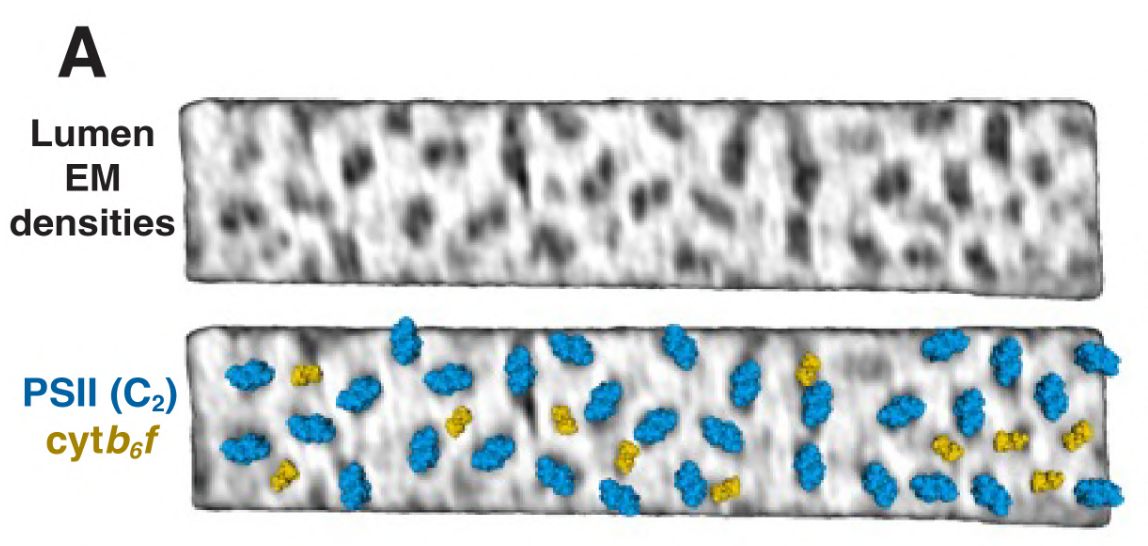

### (B) Nearest-Neighbor distances

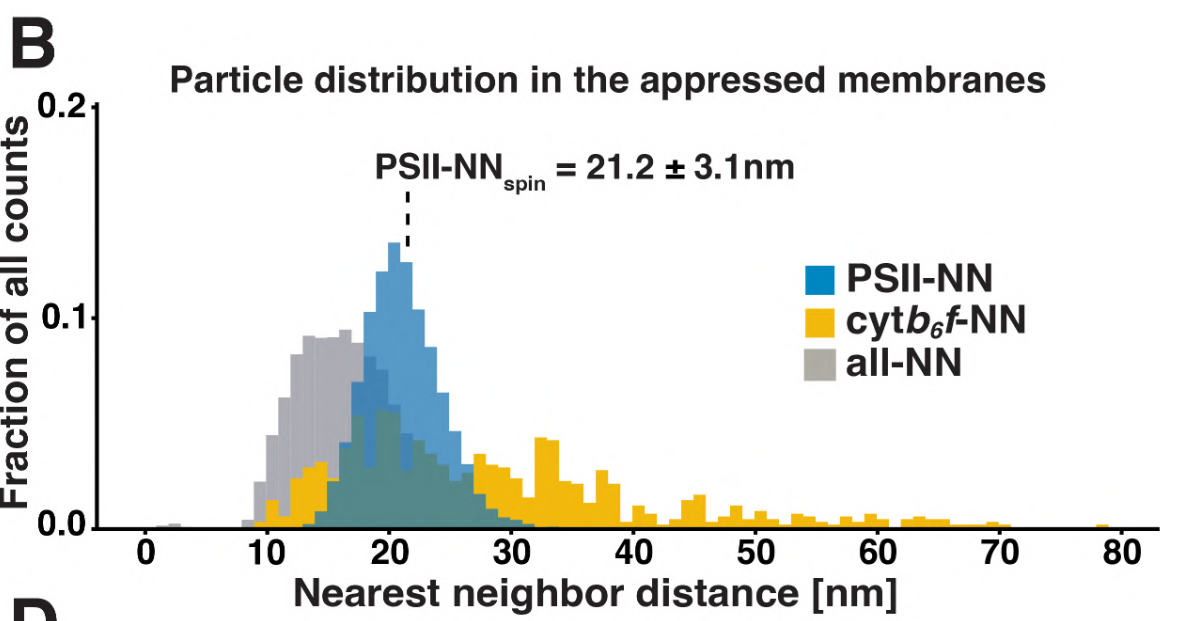

In [ ]:
# Generate reference Gaussian distribution of points
gaussian_points = generate_nn_distances(n_psii, mean=21.2, std=3.1, seed=42)
# Plot the Gaussian distribution
plt.figure(figsize=(8, 6))
plt.hist(gaussian_points, bins=10, color='blue', alpha=0.7)
plt.xlabel('Distance (nm)')
plt.ylabel('Frequency')
plt.title('Gaussian Distribution of Distances')
plt.grid()
plt.show()

In [ ]:
#From the paper, we want an average distance of 21.2 nm and a std deviation of 3.1 nm, but here we might need to adjust the target for the iteration

# Generate points on your mesh following a Gaussian NN-distance distribution
#distributed_points = distribute_points_gaussian(
#    mesh=remesh,
#    n_points=n_psii,  # Number of points you want
#    mean_distance=23,  # Your target mean distance
#    std_distance=1,    # Your target std deviation
#    seed=42             # For reproducibility
#)
distributed_points, forbidden_points = distribute_points_gaussian(
    mesh=remesh,
    n_points=n_psii,     # Number of points you want
    mean_distance=25,  # Your target mean distance
    std_distance=0.2,    # Your target std deviation
    max_attempts=10000, # Number of attempts to place each point
    forbiden_radius=10, # Radius of the forbidden cylinder (PSII size + 1.2 nm)
    forbiden_height=6,  # Height of the forbidden cylinder
    seed=42             # For reproducibility
)

# Visualize points on the mesh
plot_mesh_with_highlighted_spheres(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=11 #PSII size
)

# Analyze how well the distribution matches the target Gaussian
analysis = analyze_point_distribution(
    points=distributed_points,
    target_mean=21.2,
    target_std=3.1
)

print(f"Target distribution: mean={analysis['target_mean']:.2f}, std={analysis['target_std']:.2f}")
print(f"Actual distribution: mean={analysis['actual_mean']:.2f}, std={analysis['actual_std']:.2f}")
print(f"KS test: statistic={analysis['ks_statistic']:.4f}, p-value={analysis['ks_pvalue']:.4f}")

n_points = len(distributed_points)
print(f"Number of points distributed: {n_points}")

In [ ]:
print(distributed_points.dtype)
print(forbidden_points.dtype)

In [ ]:
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=forbidden_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=10 #PSII size
)


In [ ]:
def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side
    rectangle = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle.append([x, -half_height, 0])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle.append([half_width, y, 0])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle.append([x, half_height, 0])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle.append([-half_width, y, 0])
    
    rectangle = np.array(rectangle)
    points_per_section = len(rectangle)
    
    # Generate tube mesh
    for i, point in enumerate(resampled_points):
        t = tangents[i]
        
        # Create a simple rotation matrix (can be improved for better orientation)
        # For now, keep rectangle in XY plane and translate
        rotation = np.eye(3)
        
        # Transform rectangle points to this position
        for corner in rectangle:
            # Rotate and translate rectangle point
            tube_points.append(point + np.dot(rotation, corner))
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

In [ ]:
#Drop points in the mesh were we placed the PSII and 22nm around
def drop_points_in_sphere(mesh, points, radius=22):
    """
    Drop points in a sphere around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the sphere around each point where points will be dropped.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius
        indices_to_drop = np.where(distances <= radius)[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)

def drop_points_in_cylinder(mesh, points, radius=22, height=10):
    """
    Drop points in a cylinder around the specified points on the mesh.
    
    Parameters
    ----------
    mesh : pyvista.PolyData
        The mesh from which to drop points.
        
    points : np.ndarray
        Array of shape (n_points, 3) containing the coordinates of the center points.
        
    radius : float, default: 22
        Radius of the cylinder around each point where points will be dropped.
        
    height : float, default: 10
        Height of the cylinder.
    
    Returns
    -------
    np.ndarray
        Array of shape (n_dropped_points, 3) containing the coordinates of the dropped points.
    """
    import numpy as np
    
    # Initialize list to store dropped points
    dropped_points = []
    
    # Iterate over each point
    for point in points:
        # Calculate distances from this point to all other points in the mesh
        distances = np.linalg.norm(mesh.points - point, axis=1)
        
        # Find indices of points within the specified radius and height
        indices_to_drop = np.where((distances <= radius) & 
                                    (np.abs(mesh.points[:, 2] - point[2]) <= height))[0]
        
        # Append these points to the list of dropped points
        dropped_points.extend(mesh.points[indices_to_drop])
    
    return np.array(dropped_points)




In [ ]:
dropped_points = drop_points_in_cylinder(
    mesh=remesh,
    points=distributed_points,
    radius=11,  # Radius of the cylinder
    height=3   # Height of the cylinder
)
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=dropped_points,
    mesh_color='lightyellow',
    point_color='red',
    point_size=5
)

# Adding the cytochrome b6f

In [ ]:
#Remove points from the mesh
#remesh_without_psii = remove_points_from_mesh(remesh, dropped_points)

In [ ]:
#Try with the new mesh
distributed_points = distribute_points_gaussian(
    mesh=remesh_without_psii,
    n_points=n_cytb,  # Number of points you want
    mean_distance=40,  # Your target mean distance
    std_distance=5,    # Your target std deviation
    seed=42,             # For reproducibility
    clear_radius=1
)
# Visualize points on the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='yellow',
    point_size=5
)

#Plot psii points to the mesh
plot_mesh_with_highlighted_points(
    mesh=remesh,
    highlighted_points=distributed_points,
    mesh_color='lightyellow',
    point_color='blue',
    point_size=5
)


# NOTES

For the grana:

The average cell size in the remeshed mesh is 0.11 nm^2.
The standard deviation of the cell sizes in the remeshed mesh is 0.01 nm^2.

For the right helix:
The tube mesh has 4000 faces.
The total avg and std area of the tube mesh are 0.04 nm^2 and 0.01 nm^2, respectively.

In [ ]:
# Test the rectangular tube function
def test_rectangular_tube():
    """Simple test to visualize the rectangular tube function."""
    
    # Create a simple curved path (helix-like)
    t = np.linspace(0, 4*np.pi, 50)
    radius = 2.0
    spline_points = np.column_stack([
        radius * np.cos(t),
        radius * np.sin(t),
        t * 0.5  # Rising helix
    ])
    
    print("Testing rectangular tube creation...")
    print(f"Input spline: {len(spline_points)} points")
    
    # Test different n_points values
    test_cases = [
        {'n_points': 10, 'width': 0.5, 'height': 0.3, 'closed': False},
        {'n_points': 20, 'width': 0.8, 'height': 0.4, 'closed': False},
        {'n_points': 50, 'width': 5, 'height': 0.6, 'closed': False}
    ]
    
    # Create plotter for visualization
    plotter = pv.Plotter(shape=(1, 3), window_size=[1200, 400])
    
    for i, params in enumerate(test_cases):
        print(f"\nTest case {i+1}: n_points={params['n_points']}, "
              f"width={params['width']}, height={params['height']}")
        
        # Create tube
        tube = create_rectangular_tube(spline_points, **params)
        
        print(f"  Result: {tube.n_points} points, {tube.n_cells} cells")
        
        # Add to visualization
        plotter.subplot(0, i)
        plotter.add_mesh(tube, color='lightblue', opacity=1, show_edges=True)
        
        # Add the original spline path for reference
        spline_poly = pv.PolyData(spline_points)
        plotter.add_mesh(spline_poly, color='red', point_size=5, render_points_as_spheres=True)
        
        plotter.add_title(f"n_points={params['n_points']}")
    
    # Show visualization
    plotter.show()
    
    return test_cases

# Run the test
test_results = test_rectangular_tube()

In [ ]:
def create_rectangular_tube(spline_points, width=1.0, height=1.0, n_points=20, width_resolution=4, closed=False):
    """
    Create a rectangular tube around a set of spline points.
    
    Parameters
    ----------
    spline_points : np.ndarray
        Array of points defining the centerline path.
        
    width : float, default: 1.0
        Width of the rectangular cross-section.
        
    height : float, default: 1.0
        Height of the rectangular cross-section.
        
    n_points : int, default: 20
        Number of points along the spline to sample for cross-sections.
        
    width_resolution : int, default: 4
        Number of points per side of the rectangular cross-section.
        Higher values create smoother, more detailed cross-sections.
        
    closed : bool, default: False
        Whether the curve is a closed loop.
        
    Returns
    -------
    pyvista.PolyData
        Mesh representing the rectangular tube.
    """
    import numpy as np
    import pyvista as pv
    from scipy.interpolate import interp1d
    
    # Resample spline to n_points if necessary
    if len(spline_points) != n_points:
        # Create parameter array for original points
        t_original = np.linspace(0, 1, len(spline_points))
        
        # Create interpolation functions for each coordinate
        interp_x = interp1d(t_original, spline_points[:, 0], kind='cubic')
        interp_y = interp1d(t_original, spline_points[:, 1], kind='cubic')
        interp_z = interp1d(t_original, spline_points[:, 2], kind='cubic')
        
        # Generate new parameter array with n_points
        t_new = np.linspace(0, 1, n_points)
        
        # Interpolate to get new points
        resampled_points = np.column_stack([
            interp_x(t_new),
            interp_y(t_new),
            interp_z(t_new)
        ])
    else:
        resampled_points = spline_points
    
    # Calculate tangents and normals
    tangents = np.gradient(resampled_points, axis=0)
    
    # Normalize tangents
    tangent_lengths = np.linalg.norm(tangents, axis=1)
    tangent_lengths[tangent_lengths == 0] = 1  # Avoid division by zero
    tangents = tangents / tangent_lengths[:, np.newaxis]
    
    # Create mesh data structures
    tube_points = []
    faces = []
    
    # Generate rectangular cross-section with specified resolution
    half_width = width / 2.0
    half_height = height / 2.0
    
    # Create rectangle points with width_resolution points per side in local 2D coordinates
    rectangle_2d = []
    
    # Bottom side: left to right
    for i in range(width_resolution):
        x = -half_width + (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, -half_height])
    
    # Right side: bottom to top (excluding corners already added)
    for i in range(1, width_resolution):
        y = -half_height + (i / (width_resolution - 1)) * height
        rectangle_2d.append([half_width, y])
    
    # Top side: right to left (excluding corners already added)
    for i in range(1, width_resolution):
        x = half_width - (i / (width_resolution - 1)) * width
        rectangle_2d.append([x, half_height])
    
    # Left side: top to bottom (excluding corners already added)
    for i in range(1, width_resolution - 1):
        y = half_height - (i / (width_resolution - 1)) * height
        rectangle_2d.append([-half_width, y])
    
    rectangle_2d = np.array(rectangle_2d)
    points_per_section = len(rectangle_2d)
    
    # Generate tube mesh
    for i, center_point in enumerate(resampled_points):
        tangent = tangents[i]
        
        # Create local coordinate system at this point
        # Tangent is the Z-axis of local system
        local_z = tangent
        
        # Create a reasonable local X and Y axis
        # Choose an arbitrary vector not parallel to tangent
        if abs(local_z[2]) < 0.9:
            temp_vector = np.array([0, 0, 1])
        else:
            temp_vector = np.array([1, 0, 0])
        
        # Create local X axis (perpendicular to tangent)
        local_x = np.cross(local_z, temp_vector)
        local_x = local_x / np.linalg.norm(local_x)
        
        # Create local Y axis (perpendicular to both)
        local_y = np.cross(local_z, local_x)
        local_y = local_y / np.linalg.norm(local_y)
        
        # Create rotation matrix from local to global coordinates
        rotation_matrix = np.column_stack([local_x, local_y, local_z])
        
        # Transform rectangle points to 3D and orient them
        for local_point_2d in rectangle_2d:
            # Convert 2D rectangle point to 3D local coordinates
            local_point_3d = np.array([local_point_2d[0], local_point_2d[1], 0])
            
            # Rotate to global orientation and translate to center point
            global_point = center_point + np.dot(rotation_matrix, local_point_3d)
            tube_points.append(global_point)
        
        # Create faces between this rectangle and the previous one
        if i > 0:
            for j in range(points_per_section):
                idx1 = (i-1) * points_per_section + j
                idx2 = (i-1) * points_per_section + (j+1) % points_per_section
                idx3 = i * points_per_section + (j+1) % points_per_section
                idx4 = i * points_per_section + j
                
                # Add two triangular faces
                faces.extend([3, idx1, idx2, idx3])
                faces.extend([3, idx1, idx3, idx4])
    
    # Close the loop if requested   
    if closed and len(resampled_points) > 2:
        # Connect last cross-section to first
        for j in range(points_per_section):
            idx1 = (len(resampled_points)-1) * points_per_section + j
            idx2 = (len(resampled_points)-1) * points_per_section + (j+1) % points_per_section
            idx3 = (j+1) % points_per_section
            idx4 = j
            
            faces.extend([3, idx1, idx2, idx3])
            faces.extend([3, idx1, idx3, idx4])

    # Create mesh
    return pv.PolyData(np.array(tube_points), np.array(faces))

In [ ]:
# Test width resolution parameter
def test_width_resolution():
    """Test the width_resolution parameter to see cross-section detail."""
    
    # Create a simple straight path for clearer visualization
    t = np.linspace(0, 10, 20)
    spline_points = np.column_stack([
        t,
        np.zeros(len(t)),
        np.zeros(len(t))
    ])
    
    print("Testing width resolution parameter...")
    
    # Test different width_resolution values
    test_cases = [
        {'width_resolution': 4, 'width': 2.0, 'height': 1.0},   # Basic rectangle (4 corners)
        {'width_resolution': 8, 'width': 2.0, 'height': 1.0},   # More detailed
        {'width_resolution': 16, 'width': 2.0, 'height': 1.0}   # High detail
    ]
    
    # Create plotter for visualization
    plotter = pv.Plotter(shape=(2, 3), window_size=[1200, 800])
    
    for i, params in enumerate(test_cases):
        print(f"\nTest case {i+1}: width_resolution={params['width_resolution']}")
        
        # Create tube
        tube = create_rectangular_tube(spline_points, n_points=10, **params)
        
        print(f"  Result: {tube.n_points} points, {tube.n_cells} cells")
        print(f"  Points per cross-section: {tube.n_points // 10}")
        
        # Side view (along tube)
        plotter.subplot(0, i)
        plotter.add_mesh(tube, color='lightgreen', opacity=0.8, show_edges=True)
        plotter.add_mesh(pv.PolyData(spline_points), color='red', point_size=8, 
                        render_points_as_spheres=True)
        plotter.add_title(f"Side View - Res: {params['width_resolution']}")
        plotter.camera_position = 'yz'
        
        # End view (cross-section)
        plotter.subplot(1, i)
        plotter.add_mesh(tube, color='lightblue', opacity=0.8, show_edges=True)
        plotter.add_title(f"End View - Res: {params['width_resolution']}")
        plotter.camera_position = 'xy'
        
        # Set view to see cross-section clearly
        plotter.camera.position = (15, 0, 0)
        plotter.camera.focal_point = (0, 0, 0)
        plotter.camera.up = (0, 0, 1)
    
    plotter.show()
    
    return test_cases

# Run width resolution test
width_test_results = test_width_resolution()

In [ ]:
# Test proper rectangle centering and orientation
def test_rectangle_orientation():
    """Test that rectangles are properly centered and oriented perpendicular to spline."""
    
    print("Testing rectangle orientation and centering...")
    
    # Create test cases with different curve types
    test_cases = []
    
    # 1. Straight line (should be easy to verify)
    straight_points = np.array([
        [0, 0, 0],
        [2, 0, 0], 
        [4, 0, 0],
        [6, 0, 0]
    ])
    test_cases.append(("Straight Line", straight_points))
    
    # 2. 90-degree bend
    bend_points = np.array([
        [0, 0, 0],
        [2, 0, 0],
        [4, 0, 0], 
        [4, 2, 0],
        [4, 4, 0]
    ])
    test_cases.append(("90° Bend", bend_points))
    
    # 3. Helix (3D curve)
    t = np.linspace(0, 2*np.pi, 20)
    helix_points = np.column_stack([
        2 * np.cos(t),
        2 * np.sin(t),
        t * 0.5
    ])
    test_cases.append(("3D Helix", helix_points))
    
    # Create plotter
    plotter = pv.Plotter(shape=(1, 3), window_size=[1200, 400])
    
    for i, (name, spline_points) in enumerate(test_cases):
        print(f"\nTest case: {name}")
        
        # Create tube with clear parameters
        tube = create_rectangular_tube(
            spline_points, 
            width=1.0, 
            height=0.5, 
            n_points=10,
            width_resolution=4,
            closed=False
        )
        
        print(f"  Created tube: {tube.n_points} points, {tube.n_cells} cells")
        
        # Visualize
        plotter.subplot(0, i)
        
        # Add tube with transparency to see internal structure
        plotter.add_mesh(tube, color='lightblue', opacity=0.7, show_edges=True)
        
        # Add centerline spline for reference
        spline_poly = pv.PolyData(spline_points)
        plotter.add_mesh(spline_poly, color='red', line_width=8)
        
        # Add spline points as spheres
        plotter.add_mesh(spline_poly, color='darkred', point_size=12, 
                        render_points_as_spheres=True)
        
        plotter.add_title(name)
        
        # Set good viewing angle
        if i == 2:  # For helix, use 3D view
            plotter.view_isometric()
        else:
            plotter.view_xy()
    
    plotter.show()
    
    return test_cases

# Run orientation test
orientation_test = test_rectangle_orientation()

# Model drawing

In [ ]:
import math
def helix_radius_from_tilt(pitch, tilt_angle_deg):
    """
    Calculate the helix radius required to achieve a given tilt angle and pitch.

    Parameters:
        pitch (float): Helix pitch P (axial rise per full turn).
        tilt_angle_deg (float): Desired tilt angle α above the horizontal, in degrees.

    Returns:
        float: Required helix radius R.
    """
    # Convert degrees to radians
    alpha = math.radians(tilt_angle_deg)
    # R = P / (2π · tan(α))
    return pitch / (2 * math.pi * math.tan(alpha))



In [ ]:
radius_granum = 250.0  # Example radius in nm
height_granum = 20.0  # Example height in nm
radius_right = radius_granum + (height_granum / 2) 
tilt_angle_right = 15.9  # Desired tilt angle in degrees

pitch_right = helix_pitch_from_tilt(radius, tilt_angle_right)
print(f"Calculated pitch for right-handed helix: {pitch_right:.2f} nm")

In [ ]:
# Right-handed spiral helix
starting_point = np.array([0, 0, 0])
pitch_right = pitch_right  # Pitch of the helix
n_turns = 1  # Number of turns based on height


spline_right = helix_points = create_elliptical_helix(x0=starting_point[0], y0=starting_point[1], z0=starting_point[2], radius_x=radius_right, radius_y=radius_right, pitch=total_height_stacks/n_turns, turns=n_turns, n_points=101, chirality='right')

tube_mesh = create_rectangular_tube(spline_right, width=height_granum, height=height_granum, n_points=101, width_resolution=4, closed=False)

# Create a Plotter object
plot_right_helix = pv.Plotter(window_size=[1600, 600])
plot_right_helix.background_color = 'black'
# Add the right-handed helix mesh
plot_right_helix.add_mesh(tube_mesh, color='lightblue', show_edges=True)
# Show axes and origin
plot_right_helix.show_axes()

# Show the plot
plot_right_helix.show()

In [ ]:
def redistribute_loop_points(loop_points, n_new_points=100):
    """
    Redistribute points along a loop using arc length parameterization.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Original loop points (N, 3).
    n_new_points : int
        Number of new evenly distributed points.
        
    Returns
    -------
    new_points : np.ndarray
        Redistributed points (n_new_points, 3).
    """
    import numpy as np
    from scipy.interpolate import interp1d
    
    # Ensure loop is closed
    if not np.allclose(loop_points[0], loop_points[-1]):
        loop_points = np.vstack([loop_points, loop_points[0]])
    
    # Calculate cumulative arc length
    distances = np.linalg.norm(np.diff(loop_points, axis=0), axis=1)
    cumulative_length = np.concatenate([[0], np.cumsum(distances)])
    total_length = cumulative_length[-1]
    
    # Normalize to [0, 1]
    normalized_length = cumulative_length / total_length
    
    # Create interpolation functions for each coordinate
    interp_x = interp1d(normalized_length, loop_points[:, 0], kind='cubic', assume_sorted=True)
    interp_y = interp1d(normalized_length, loop_points[:, 1], kind='cubic', assume_sorted=True)
    interp_z = interp1d(normalized_length, loop_points[:, 2], kind='cubic', assume_sorted=True)
    
    # Generate evenly spaced parameters
    new_params = np.linspace(0, 1, n_new_points, endpoint=False)
    
    # Interpolate new points
    new_points = np.column_stack([
        interp_x(new_params),
        interp_y(new_params),
        interp_z(new_params)
    ])
    
    return new_points

# Example usage
def test_loop_redistribution():
    """Test the loop redistribution workflow."""
    
    # Create a test loop (ellipse with irregular sampling)
    t_irregular = np.array([0, 0.1, 0.15, 0.3, 0.8, 1.2, 1.8, 2.5, 3.0, 4.0, 5.0, 6.0]) 
    original_loop = np.column_stack([
        3 * np.cos(t_irregular),
        2 * np.sin(t_irregular),
        0.5 * np.sin(2 * t_irregular)
    ])
    
    print(f"Original loop: {len(original_loop)} points")
    
    # Redistribute points evenly
    redistributed_loop = redistribute_loop_points(original_loop, n_new_points=50)
    
    print(f"Redistributed loop: {len(redistributed_loop)} points")
    
    # Visualize both loops
    plotter = pv.Plotter(shape=(1, 2), window_size=[1200, 600])
    
    # Original loop
    plotter.subplot(0, 0)
    original_poly = pv.PolyData(original_loop)
    lines_orig = []
    for i in range(len(original_loop)):
        lines_orig.extend([2, i, (i + 1) % len(original_loop)])
    original_poly.lines = lines_orig
    
    plotter.add_mesh(original_poly, color='red', line_width=3, label='Original')
    plotter.add_mesh(pv.PolyData(original_loop), color='red', point_size=10, 
                    render_points_as_spheres=True)
    plotter.add_title("Original Irregular Loop")
    
    # Redistributed loop
    plotter.subplot(0, 1)
    redist_poly = pv.PolyData(redistributed_loop)
    lines_redist = []
    for i in range(len(redistributed_loop)):
        lines_redist.extend([2, i, (i + 1) % len(redistributed_loop)])
    redist_poly.lines = lines_redist
    
    plotter.add_mesh(redist_poly, color='blue', line_width=3, label='Redistributed')
    plotter.add_mesh(pv.PolyData(redistributed_loop), color='blue', point_size=8, 
                    render_points_as_spheres=True)
    plotter.add_title("Redistributed Even Loop")
    
    plotter.show()
    
    return original_loop, redistributed_loop

# Run test
original, redistributed = test_loop_redistribution()

In [ ]:
import numpy as np
import pyvista as pv
from scipy.interpolate import interp1d

def redistribute_loop_points(loop_points, n_points=50):
    """
    Redistribute points along a loop using arc length parameterization.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Original loop points (N, 3).
    n_points : int
        Number of evenly distributed points.
        
    Returns
    -------
    new_points : np.ndarray
        Redistributed points (n_points, 3).
    """
    # Ensure loop is closed
    if not np.allclose(loop_points[0], loop_points[-1]):
        loop_points = np.vstack([loop_points, loop_points[0]])
    
    # Calculate cumulative arc length
    distances = np.linalg.norm(np.diff(loop_points, axis=0), axis=1)
    cumulative_length = np.concatenate([[0], np.cumsum(distances)])
    total_length = cumulative_length[-1]
    
    # Normalize to [0, 1]
    normalized_length = cumulative_length / total_length
    
    # Create interpolation functions for each coordinate
    interp_x = interp1d(normalized_length, loop_points[:, 0], kind='cubic', assume_sorted=True)
    interp_y = interp1d(normalized_length, loop_points[:, 1], kind='cubic', assume_sorted=True)
    interp_z = interp1d(normalized_length, loop_points[:, 2], kind='cubic', assume_sorted=True)
    
    # Generate evenly spaced parameters
    new_params = np.linspace(0, 1, n_points, endpoint=False)
    
    # Interpolate new points
    new_points = np.column_stack([
        interp_x(new_params),
        interp_y(new_params),
        interp_z(new_params)
    ])
    
    return new_points


def calculate_loop_centroid(loop_points):
    """
    Calculate the centroid of a loop.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Loop points (N, 3).
        
    Returns
    -------
    centroid : np.ndarray
        Centroid point (3,).
    """
    return np.mean(loop_points, axis=0)


def scale_loop_from_centroid(loop_points, scale_factor, centroid=None):
    """
    Scale a loop from its centroid.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Original loop points (N, 3).
    scale_factor : float
        Scaling factor (1.0 = original size, 0.5 = half size).
    centroid : np.ndarray, optional
        Centroid point. If None, calculated automatically.
        
    Returns
    -------
    scaled_points : np.ndarray
        Scaled loop points (N, 3).
    """
    if centroid is None:
        centroid = calculate_loop_centroid(loop_points)
    
    # Scale from centroid
    scaled_points = centroid + scale_factor * (loop_points - centroid)
    
    return scaled_points


def create_concentric_rings(loop_points, n_rings=5, n_points_per_ring=50):
    """
    Create concentric rings by scaling the original loop.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Original boundary loop points (N, 3).
    n_rings : int
        Number of interior rings to create.
    n_points_per_ring : int
        Number of points per ring.
        
    Returns
    -------
    all_rings : list of np.ndarray
        List of ring point arrays, from outer to inner.
    centroid : np.ndarray
        Loop centroid.
    """
    # Redistribute boundary points for even spacing
    boundary_ring = redistribute_loop_points(loop_points, n_points_per_ring)
    centroid = calculate_loop_centroid(boundary_ring)
    
    # Create scale factors from 1.0 (boundary) to near 0 (center)
    scale_factors = np.linspace(1.0, 0.1, n_rings)
    
    # Generate concentric rings
    rings = []
    for scale in scale_factors:
        ring = scale_loop_from_centroid(boundary_ring, scale, centroid)
        rings.append(ring)
    
    return rings, centroid


def triangulate_concentric_rings(rings, centroid):
    """
    Create triangular mesh from concentric rings.
    
    Parameters
    ----------
    rings : list of np.ndarray
        List of ring point arrays, from outer to inner.
    centroid : np.ndarray
        Center point.
        
    Returns
    -------
    surface : pv.PolyData
        Triangulated surface mesh.
    """
    # Combine all ring points and add centroid
    all_points = []
    ring_starts = []
    
    for ring in rings:
        ring_starts.append(len(all_points))
        all_points.extend(ring)
    
    # Add centroid at the end
    center_idx = len(all_points)
    all_points.append(centroid)
    
    all_points = np.array(all_points)
    n_points_per_ring = len(rings[0])
    
    # Create triangular faces
    faces = []
    
    # Connect between rings
    for i in range(len(rings) - 1):
        start_outer = ring_starts[i]
        start_inner = ring_starts[i + 1]
        
        for j in range(n_points_per_ring):
            # Current and next point indices in each ring
            j_next = (j + 1) % n_points_per_ring
            
            # Outer ring indices
            outer_curr = start_outer + j
            outer_next = start_outer + j_next
            
            # Inner ring indices
            inner_curr = start_inner + j
            inner_next = start_inner + j_next
            
            # Create two triangles between rings
            # Triangle 1: outer_curr -> outer_next -> inner_curr
            faces.extend([3, outer_curr, outer_next, inner_curr])
            
            # Triangle 2: outer_next -> inner_next -> inner_curr
            faces.extend([3, outer_next, inner_next, inner_curr])
    
    # Connect innermost ring to center point
    innermost_start = ring_starts[-1]
    for j in range(n_points_per_ring):
        j_next = (j + 1) % n_points_per_ring
        
        inner_curr = innermost_start + j
        inner_next = innermost_start + j_next
        
        # Triangle from center to innermost ring edge
        faces.extend([3, center_idx, inner_curr, inner_next])
    
    # Create PyVista mesh
    surface = pv.PolyData(all_points, faces)
    
    return surface


def create_ring_based_surface(loop_points, n_rings=5, n_points_per_ring=50):
    """
    Create a triangulated surface using concentric ring approach.
    
    Parameters
    ----------
    loop_points : np.ndarray
        Original boundary loop points (N, 3).
    n_rings : int
        Number of concentric rings.
    n_points_per_ring : int
        Points per ring for triangulation.
        
    Returns
    -------
    surface : pv.PolyData
        Triangulated surface mesh.
    rings : list
        Generated rings for visualization.
    centroid : np.ndarray
        Loop centroid.
    """
    print(f"Creating ring-based surface...")
    print(f"  Rings: {n_rings}, Points per ring: {n_points_per_ring}")
    
    # Step 1: Create concentric rings
    rings, centroid = create_concentric_rings(loop_points, n_rings, n_points_per_ring)
    print(f"  Generated {len(rings)} concentric rings")
    
    # Step 2: Triangulate rings
    surface = triangulate_concentric_rings(rings, centroid)
    print(f"  Created surface: {surface.n_points} points, {surface.n_cells} triangles")
    
    return surface, rings, centroid

In [ ]:
surface, rings, centroid = create_ring_based_surface(original)

# Remesh with pyacvd
clus = pyacvd.Clustering(surface.subdivide(2))
clus.cluster(1000)
remesh = clus.create_mesh()


In [ ]:
surface_from_loop = pv.PolyData(original)
surface_from_loop = surface_from_loop.triangulate()

In [ ]:
#surface = pv.PolyData(redistributed).delaunay_2d()  # Better surface quality

plotter = pv.Plotter(window_size=[1200, 600])
plotter.add_mesh(surface_from_loop, color='lightblue', show_edges=True)
plotter.add_mesh(pv.PolyData(redistributed), color='red', point_size=10, 
                render_points_as_spheres=True)
plotter.add_title("Delaunay Surface from Redistributed Loop")
plotter.show()
